# Evaluating synthetic yeast promoters using Polygraph

In [1]:
import numpy as np
import pandas as pd
import plotnine as p9
import seaborn as sns
import matplotlib.pyplot as plt

import polygraph.input, polygraph.embedding, polygraph.motifs, polygraph.models, polygraph.sequence, polygraph.utils, polygraph.visualize, polygraph.stats
pd.set_option('display.precision', 2)
%matplotlib inline

/opt/conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


## Read data

The input file should be a tab or comma separated file with two columns. The first column contains the sequence and the second contains the group. The `read_seqs` function will assign a unique ID to each sequence.

In [2]:
seqs = polygraph.input.read_seqs('yeast_seqs.txt')
seqs.head()

,Sequence,Group
SeqID,,
seq_0,GATGAGTGAAAAATCGTAATGAGTCAGCAAATCACTCTGTACGTTA...,native_high
seq_1,CATCGACTTATTTTTTTTTTTTGATGAAATTTTTCAGATTTTACAA...,native_high
seq_2,GCCTCTTATTTTTTTTTTTTTCGATTTTTGGCCCACAGGTCATATT...,native_high
seq_3,GATGAGTGAAAAATCGTAATGAGTCAGCAAATCACTGTGTACGTTA...,native_high
seq_4,AGAGCGACGCAAACAGCGCGCAGACTCTACGGGTAATAGACTCACA...,native_high


This dataset contains the sequences of selected native yeast promoters as well as 50 random sequences and 50 synthetic promoters each generated by evolution and gradient (Ledidi) methods starting from the random sequences. Further, we have 50 sequences that were generated using the `polygraph.evolve.evolve` function, which optimizes for both predicted activity and similarity to native promoters.

In [3]:
print(seqs.Group.value_counts())

Group
native_high         50
native_low          50
random              50
evolution           50
gradient            50
guided_evolution    50
Name: count, dtype: int64


# 1. Evaluate sequence content

## 1.1 GC content

GC content is the fraction of bases in each sequence that are either G or C. We plot a box+violin plot of GC content for each group.

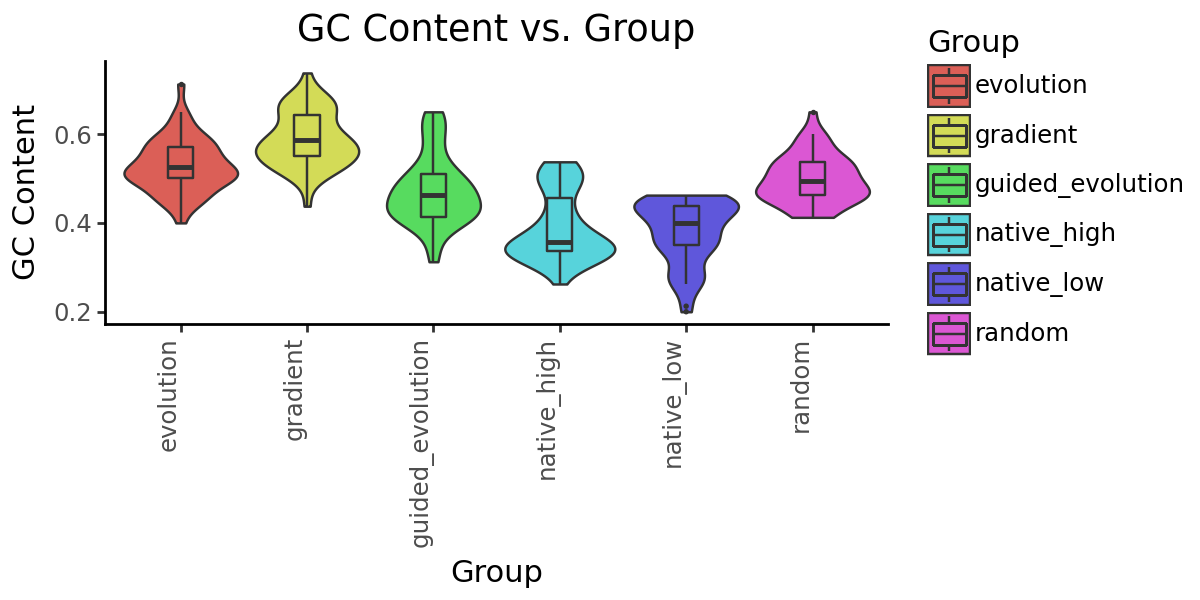

In [4]:
seqs['GC Content'] = polygraph.sequence.gc(seqs)
polygraph.visualize.boxplot(seqs, value_col='GC Content') + p9.theme(figure_size=(6,3))

We perform a Kruskal-Wallis test followed by Dunn's post-hoc test to identify significant differences in GC content between groups. This returns a dictionary containing keys 'Kruskal' for the Kruskal-Wallis p-value and 'Dunn' for the Dunn's post-hoc test p-values.

In [5]:
test_results = polygraph.stats.kruskal_dunn(data=seqs, val_col="GC Content")
test_results['Kruskal']

1.0667060077212982e-34

The Kruskal-Wallis p-value suggests that there are significant between-group differences in GC content. We look at the Dunn's post-hoc test results to see the p-values for pairwise comparisons between all groups. Look at the row "native_high" to see which groups are significantly different from the native strong promoters.

In [6]:
test_results['Dunn'].style.applymap(lambda x: "background-color: red" if x<.01 else None)

/tmp/ipykernel_535662/4098636107.py:1: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.


,evolution,gradient,guided_evolution,native_high,native_low,random
evolution,1.000000,0.006592,0.000837,0.000000,0.000000,0.095132
gradient,0.006592,1.000000,0.000000,0.000000,0.000000,0.000012
guided_evolution,0.000837,0.000000,1.000000,0.000227,0.000025,0.095132
native_high,0.000000,0.000000,0.000227,1.000000,0.590016,0.000000
native_low,0.000000,0.000000,0.000025,0.590016,1.000000,0.000000
random,0.095132,0.000012,0.095132,0.000000,0.000000,1.000000


Note that the GC content results have also been added to the `seqs` data frame! So you can do other analyses with them if you like.

In [7]:
seqs.head()

,Sequence,Group,GC Content
SeqID,,,
seq_0,GATGAGTGAAAAATCGTAATGAGTCAGCAAATCACTCTGTACGTTA...,native_high,0.34
seq_1,CATCGACTTATTTTTTTTTTTTGATGAAATTTTTCAGATTTTACAA...,native_high,0.26
seq_2,GCCTCTTATTTTTTTTTTTTTCGATTTTTGGCCCACAGGTCATATT...,native_high,0.46
seq_3,GATGAGTGAAAAATCGTAATGAGTCAGCAAATCACTGTGTACGTTA...,native_high,0.35
seq_4,AGAGCGACGCAAACAGCGCGCAGACTCTACGGGTAATAGACTCACA...,native_high,0.50


For example, we can look at the mean per group:

In [8]:
seqs.groupby('Group')['GC Content'].mean()

Group
evolution           0.53
gradient            0.59
guided_evolution    0.47
native_high         0.39
native_low          0.38
random              0.50
Name: GC Content, dtype: float64

## 1.2 length distribution

Just to illustrate the function, we look at the sequence length distribution for all groups. Nothing to see here, since we generated sequences that are all of the same length.

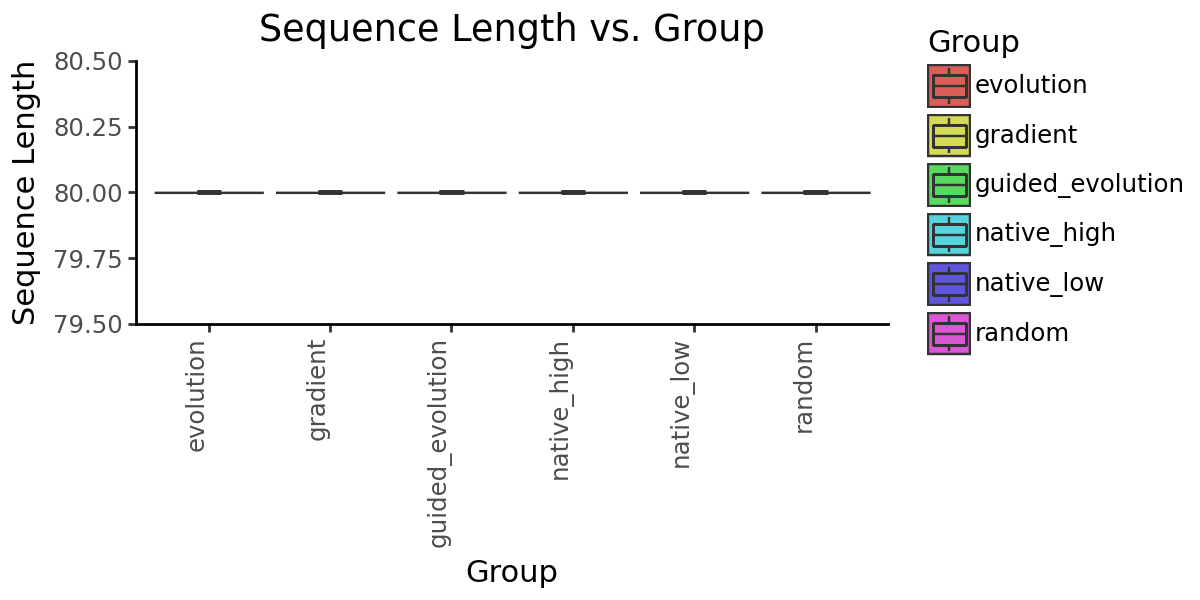

In [9]:
seqs['Sequence Length'] = seqs.Sequence.apply(len)
polygraph.visualize.boxplot(seqs, value_col='Sequence Length') + p9.theme(figure_size=(6,3))

## 1.3 Edit distance (compared to the nearest reference sequence)

This function calculates the number of edits required to convert a synthetic sequence into the most similar sequence from the reference group, which in this case is "native_high".

In [10]:
seqs['edit'] = polygraph.sequence.min_edit_distance_from_reference(seqs, reference_group='native_high')

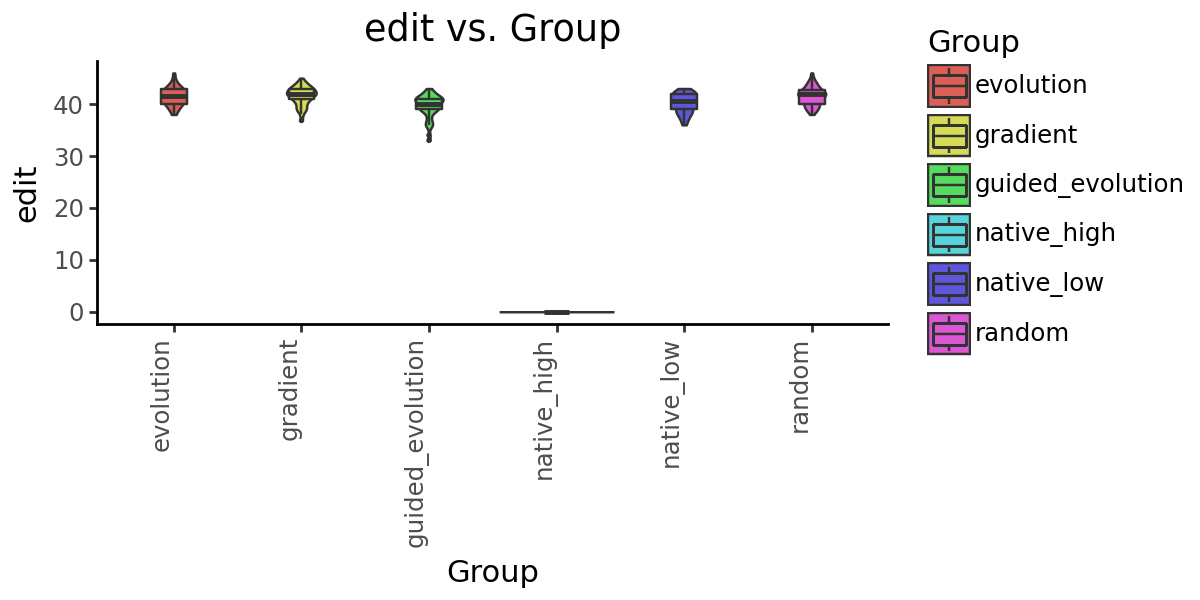

In [11]:
polygraph.visualize.boxplot(seqs, value_col='edit') + p9.theme(figure_size=(6, 3))

In [12]:
test_results = polygraph.stats.kruskal_dunn(data=seqs, val_col="edit")
test_results['Kruskal']

2.422077729497211e-31

In [13]:
test_results['Dunn'].style.applymap(lambda x: "background-color: red" if x<.01 else None)

/tmp/ipykernel_535662/4098636107.py:1: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.


,evolution,gradient,guided_evolution,native_high,native_low,random
evolution,1.000000,0.596580,0.001379,0.000000,0.017896,0.811641
gradient,0.596580,1.000000,0.000143,0.000000,0.002930,0.730812
guided_evolution,0.001379,0.000143,1.000000,0.000000,0.463115,0.000645
native_high,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
native_low,0.017896,0.002930,0.463115,0.000000,1.000000,0.009831
random,0.811641,0.730812,0.000645,0.000000,0.009831,1.000000


## 1.4 k-mer content

Edit distance is not necessarily the best way to compare sequences. To compare groups of sequences in different ways, we will be embedding all our sequences in various embedding spaces based on their sequence and regulatory content. First, we will calculate the k-mer content in all sequences. You can set k to any value and choose whether to normalize based on sequence length.

### 1.4.1 Compute k-mer content

In [14]:
%%time
kmers = polygraph.sequence.kmer_frequencies(seqs=seqs, k=5, normalize=True)
print(kmers.shape)
kmers.iloc[:5, :5]

(300, 1024)
CPU times: user 382 ms, sys: 2.93 ms, total: 385 ms
Wall time: 384 ms


,AAAAA,AAAAC,AAAAG,AAAAT,AAACA
SeqID,,,,,
seq_0,0.01,0.00,0.0,0.01,0.00
seq_1,0.01,0.01,0.0,0.00,0.00
seq_2,0.01,0.01,0.0,0.00,0.00
seq_3,0.01,0.00,0.0,0.01,0.00
seq_4,0.00,0.00,0.0,0.00,0.01


Each sequence is now represented as a 4^5 = 1024-dimensional vector. We can now compute various statistics on the sequences in this vector space.

### 1.4.2 Compute statistics

We have one handy function to compute lots of different statistics on the embedded sequences. The results are all combined into an `AnnData` object. You can also perform each analysis separately if you prefer.

In [15]:
%%time
kmer_emb = polygraph.embedding.embedding_analysis(
    kmers, seqs, reference_group='native_high', use_pca=True)

Creating AnnData object
PCA


/opt/conda/lib/python3.11/site-packages/scanpy/preprocessing/_pca.py:317: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.


Fraction of total variance explained by PCA components:  0.6348119988012595
UMAP
Differential feature abundance
1-NN statistics
Within-group KNN diversity
Euclidean distance to nearest reference
Distribution shift
Train groupwise classifiers


/opt/conda/lib/python3.11/site-packages/scikit_posthocs/_posthocs.py:368: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/opt/conda/lib/python3.11/site-packages/scikit_posthocs/_posthocs.py:371: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/opt/conda/lib/python3.11/site-packages/scikit_posthocs/_posthocs.py:368: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/opt/conda/lib/python3.11/site-packages/scikit_posthocs/_posthocs.py:3

CPU times: user 41.6 s, sys: 19.2 s, total: 1min
Wall time: 9.37 s


### 1.4.3 PCA visualization

First, we can visualize the distribution of the sequences in k-mer embedding space.

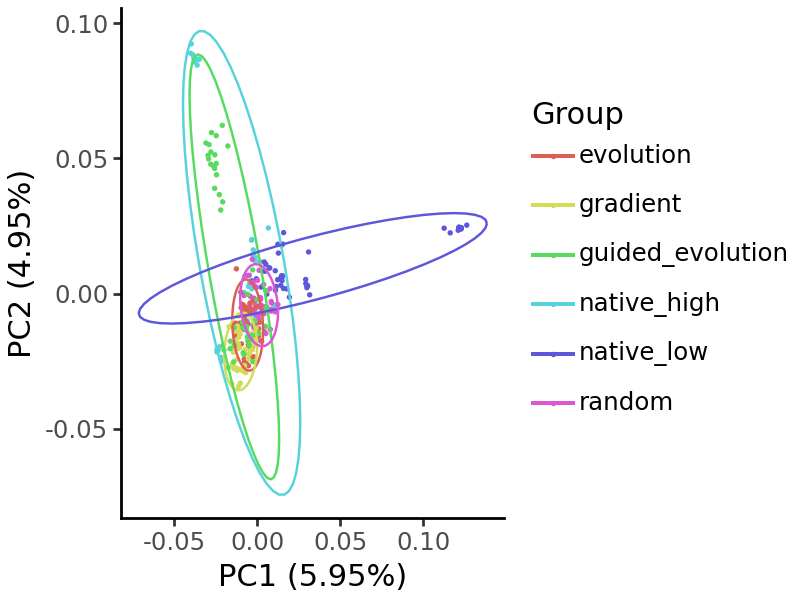

In [16]:
polygraph.visualize.pca_plot(kmer_emb, show_ellipse=True) + p9.theme(figure_size=(4,3))

### 1.4.4 k-mer overlap

First, we ask: are there k-mers that are only present in a subset of groups? We can visualize this in an UpSet plot, which shows the number of k-mers that are present in various subsets of groups.

/opt/conda/lib/python3.11/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


/opt/conda/lib/python3.11/site-packages/upsetplot/plotting.py:796: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=Tru

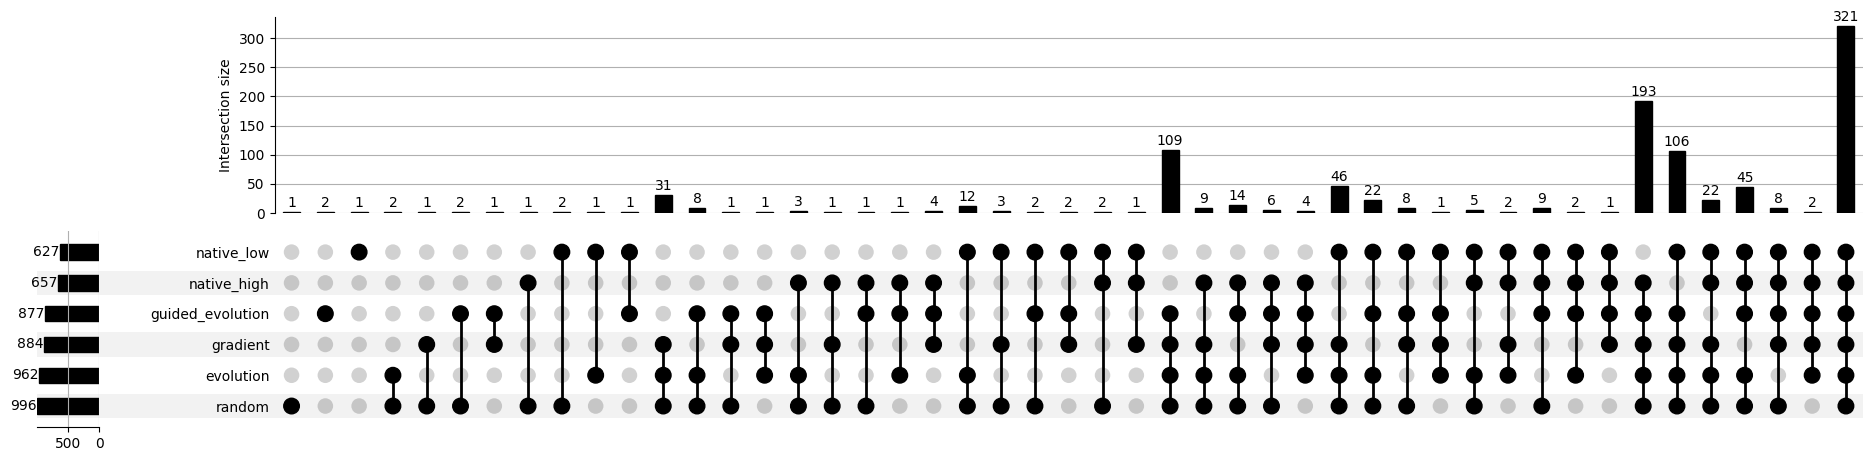

In [19]:
polygraph.visualize.upset_plot(kmer_emb)

### 1.4.5 Differential k-mer abundance

Even if a k-mer is present in multiple groups, its frequency may be different. We performed a statistical test to compare the frequency of each k-mer in each synthetic group to its frequency in the reference group ("native high"). The test results are stored in `emb.uns["DE_test"]`.

In [21]:
test_results = kmer_emb.uns["DE_test"]
test_results.head()

,Group,value,score,padj,log2FC
0,evolution,AATGA,-4.53,5.96e-03,-3.51
1,evolution,TGAAA,-4.05,2.66e-02,-3.05
2,evolution,AAAAA,-3.95,2.70e-02,-2.97
3,evolution,GAAAA,-3.63,5.60e-02,-2.59
4,evolution,TCGCG,3.62,5.60e-02,22.65


By looking at this object, we can see how many k-mers are significantly more/less abundant in each group of synthetic promoters.

In [22]:
print("Number of differential k-mers compared to reference")
print(test_results[test_results.padj < .01].Group.value_counts())

print("")

print("Top Differential k-mers")
print(test_results[test_results.padj < .01].sort_values('padj').head())

Number of differential k-mers compared to reference
Group
native_low    9
gradient      8
random        4
evolution     1
Name: count, dtype: int64

Top Differential k-mers
           Group  value  score      padj  log2FC
1023    gradient  GCGCG   6.60  4.18e-08    2.80
3069  native_low  TTTTT  -6.20  5.62e-07  -23.47
4092      random  TTTTT  -5.89  4.02e-06   -4.47
1024    gradient  CGCGC   5.76  4.22e-06    2.55
3070  native_low  TTTTC  -5.52  1.71e-05   -5.14


### 1.4.6 1-nearest neighbor fraction

For each synthetic group, we take the embeddings for all the sequences of that group, plus all the sequences of the reference group ("native_high"). We then ask, what fraction of synthetic sequences have a nearest neighbor that is in the reference group? This is a way to assess whether the synthetic sequences are clustered with each other, or are mixed among the reference sequences. 

Note that this analysis is performed one at a time for each synthetic group; we are not comparing the synthetic groups with each other. We will demonstrate how to do that later.

The raw results for this analysis are stored in `emb.obs`. But we can summarize them in a bar plot:

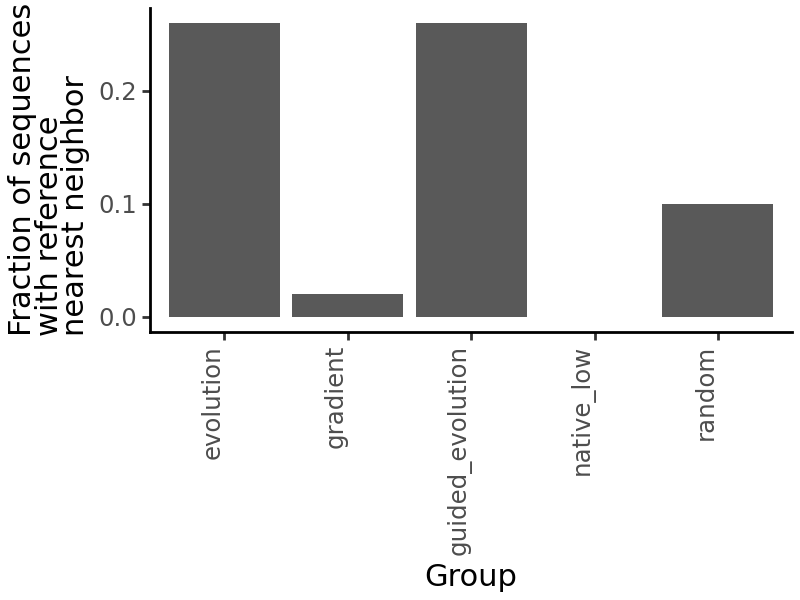

In [23]:
# Plot
polygraph.visualize.one_nn_frac_plot(kmer_emb, reference_group="native_high") + p9.theme(figure_size=(4,3))

We also compute p-values for each group using Fisher's exact test. A significant p-value suggests that the synthetic and reference sequences are not well mixed.

In [24]:
kmer_emb.uns["1NN_ref_prop_test"]

,group_prop,ref_prop,pval,padj
Group,,,,
native_low,0.00,0.96,2.63e-26,1.31e-25
random,0.10,0.96,6.18e-20,1.03e-19
evolution,0.26,0.96,9.78e-14,1.22e-13
gradient,0.02,0.96,1.24e-24,3.10e-24
guided_evolution,0.26,0.92,8.37e-12,8.37e-12


### 1.4.7 Distance to the closest reference sequence

Another way of assessing separation between the synthetic sequences and reference sequences in embedding space is by calculating the distance between each synthetic sequence and the closest reference sequence to it in embedding space. Again, the results are stored in `emb.obs`, but we can conveniently visualize them:

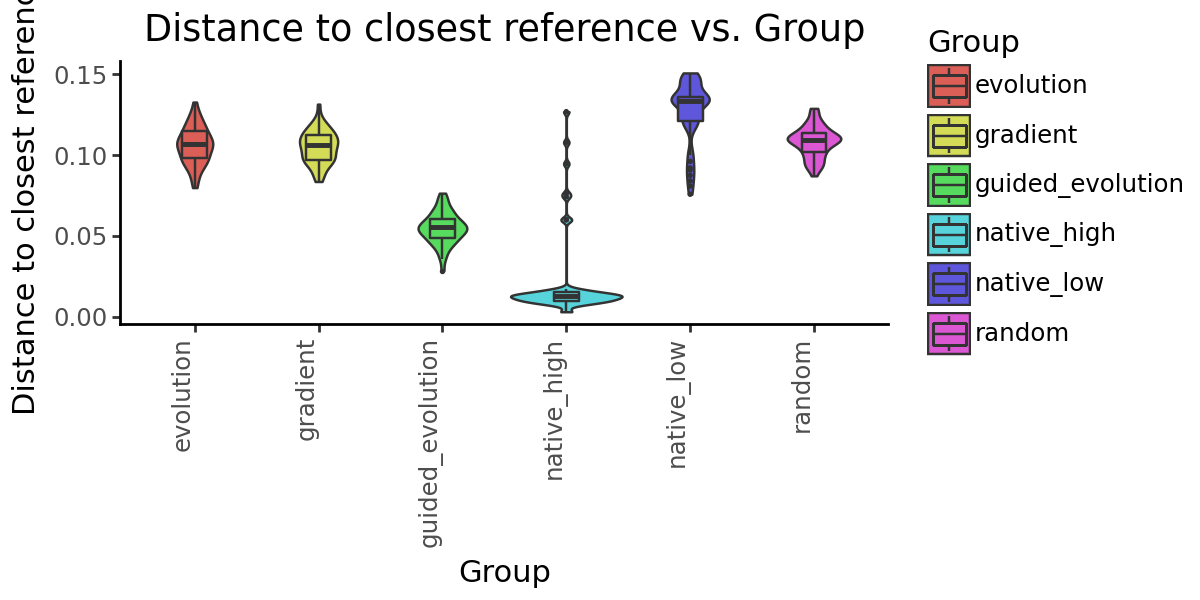

In [25]:
polygraph.visualize.boxplot(kmer_emb.obs, value_col='Distance to closest reference') + p9.theme(figure_size=(6,3))

In [26]:
test_results = kmer_emb.uns["ref_dist_test"]
test_results["Kruskal"]

2.2286046759511646e-44

In [27]:
test_results['Dunn'].style.applymap(lambda x: "background-color: red" if x<.01 else None)

/tmp/ipykernel_535662/4098636107.py:1: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.


,evolution,gradient,guided_evolution,native_high,native_low,random
evolution,1.000000,0.801577,0.000000,0.000000,0.000126,0.556406
gradient,0.801577,1.000000,0.000000,0.000000,0.000048,0.427392
guided_evolution,0.000000,0.000000,1.000000,0.084378,0.000000,0.000000
native_high,0.000000,0.000000,0.084378,1.000000,0.000000,0.000000
native_low,0.000126,0.000048,0.000000,0.000000,1.000000,0.001377
random,0.556406,0.427392,0.000000,0.000000,0.001377,1.000000


### 1.4.8 Diversity (K-Nearest Neighbor distance)

We compute the mean distance between each sequence and its k nearest neighbors from the same group. This is a way to measure the diversity of synthetic sequences; a large value means that the sequences in the group are spread out in embedding space, while small values mean they cluster together. k is set to 10 by default. Again, the results are stored in `emb.obs`, but we can conveniently visualize them:

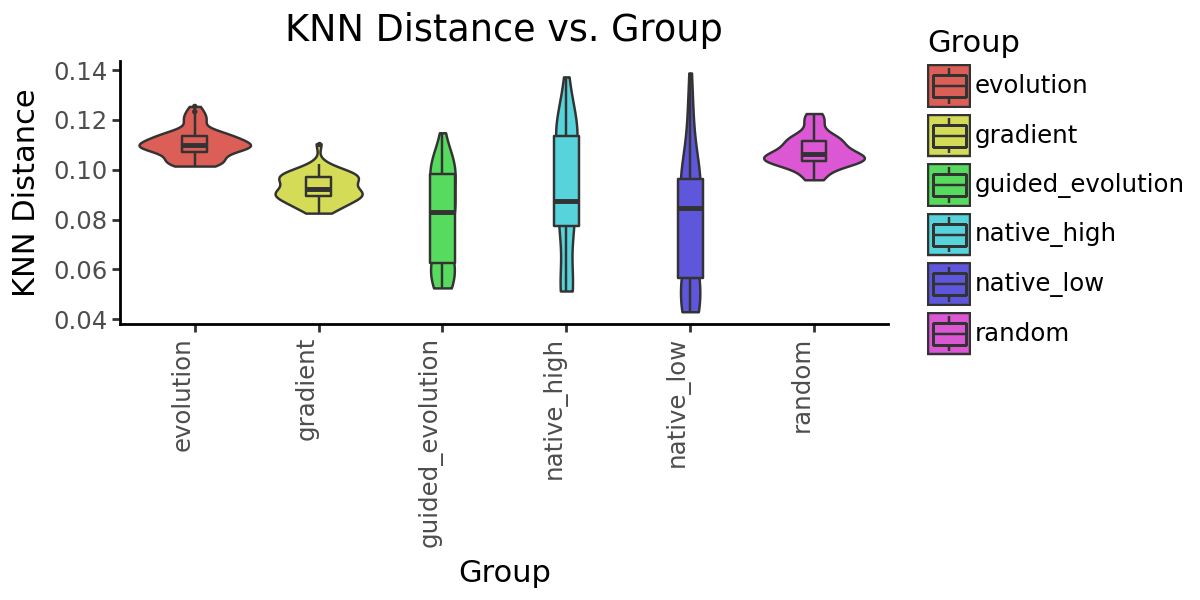

In [28]:
polygraph.visualize.boxplot(kmer_emb.obs, value_col='KNN Distance') + p9.theme(figure_size=(6,3))

In [29]:
test_results = kmer_emb.uns["knn_dist_test"]
test_results["Kruskal"]

8.900023087508012e-24

In [30]:
test_results['Dunn'].style.applymap(lambda x: "background-color: red" if x<.01 else None)

/tmp/ipykernel_535662/4098636107.py:1: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.


,evolution,gradient,guided_evolution,native_high,native_low,random
evolution,1.000000,0.000000,0.000000,0.000004,0.000000,0.231090
gradient,0.000000,1.000000,0.137302,0.112566,0.178313,0.000000
guided_evolution,0.000000,0.137302,1.000000,0.001422,0.860905,0.000000
native_high,0.000004,0.112566,0.001422,1.000000,0.002368,0.000850
native_low,0.000000,0.178313,0.860905,0.002368,1.000000,0.000000
random,0.231090,0.000000,0.000000,0.000850,0.000000,1.000000


## 1.4.9 Distribution shift

Instead of comparing individual sequences to the reference group, we can compare the overall distribution of each group in the embedding space to that of the reference group. This uses Hotelling's T2 test to compute a p-value for each group separately.

In [31]:
kmer_emb.uns['dist_shift_test']

,t2_stat,fval,pval,padj
Group,,,,
native_high,0.00,0.00,1.00e+00,1.00e+00
native_low,31914.30,319.14,8.43e-48,5.06e-47
random,3026.84,30.27,7.98e-24,1.60e-23
evolution,1517.00,15.17,3.07e-17,4.61e-17
gradient,3615.98,36.16,1.41e-25,4.24e-25
guided_evolution,858.16,8.58,3.28e-12,3.93e-12


### 1.4.10 Groupwise classifiers

For each group of synthetic sequences, we train a separate Support Vector Machine (SVM) classifer to distinguish them from the reference ("native_high") sequences based on their k-mer embedding. High performance of the classifier indicates that the sequences are easy to discriminate:

In [32]:
kmer_emb.uns['svm_performance']

,Accuracy,AUROC
Group,,
native_low,0.99,0.99
random,0.99,0.99
evolution,0.97,0.97
gradient,0.99,0.99
guided_evolution,0.88,0.88


## 1.5 All-to-all comparisons

Some of the above analyses compare each group of synthetic sequences to the reference group (native_high) one at a time. We may also want to understand how similar these groups are to each other. Below are some all-to-all comparisons.

### 1.5.1 Mean edit distance between all sequences in all groups

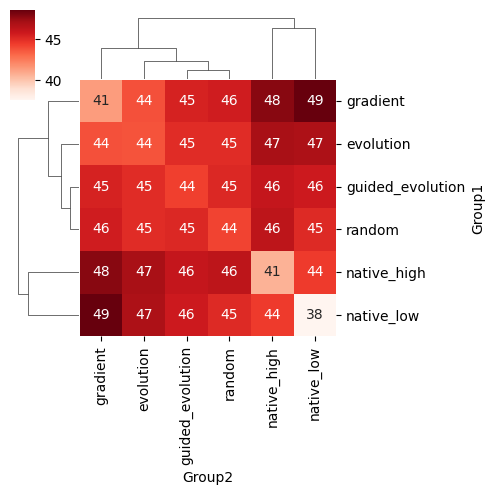

In [33]:
mean_edit = polygraph.sequence.groupwise_mean_edit_dist(seqs)
sns.clustermap(mean_edit, annot=True, cmap="Reds", figsize=(5,5))

### 1.5.2 All-to-all fraction of sequences whose nearest neighbors belong to different groups.

In [34]:
kmer_emb = polygraph.embedding.all_1nn(kmer_emb, reference_group="native_high", use_pca=True)

/opt/conda/lib/python3.11/site-packages/polygraph/embedding.py:219: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
/opt/conda/lib/python3.11/site-packages/polygraph/stats.py:68: RuntimeWarning: divide by zero encountered in log2
/opt/conda/lib/python3.11/site-packages/polygraph/stats.py:68: RuntimeWarning: divide by zero encountered in log2
/opt/conda/lib/python3.11/site-packages/polygraph/stats.py:68: RuntimeWarning: divide by zero encountered in log2
/opt/conda/lib/python3.11/site-packages/polygraph/stats.py:68: RuntimeWarning: divide by zero encountered in log2


In [35]:
kmer_emb.uns['1NN_group_probs'].T.style.background_gradient("Blues")

Group,evolution,gradient,guided_evolution,native_high,native_low,random
one_nn_group,,,,,,
evolution,0.000000,0.800000,0.000000,0.000000,0.000000,1.000000
gradient,0.040000,0.100000,0.000000,0.000000,0.000000,0.000000
guided_evolution,0.000000,0.000000,0.740000,0.060000,0.000000,0.000000
native_high,0.000000,0.000000,0.260000,0.920000,0.000000,0.000000
native_low,0.000000,0.000000,0.000000,0.020000,1.000000,0.000000
random,0.960000,0.100000,0.000000,0.000000,0.000000,0.000000


## 1.6 Gapped k-mer embedding

Instead of a simple k-mer frequency based embedding, we can count gapped k-mers (k-mers with some frequency of mismatches allowed). Here, we can set the value of k (k-mer length) and also m (maximum number of mismatches).

### 1.6.1 count gapped k-mers

In [ ]:
# Count k-mers of length 5 with 2 mismatches
gkm = polygraph.sequence.fastsk(seqs, k=5, m=2)

### 1.6.2 Compute statistics

In [49]:
%%time
gkm_emb = polygraph.embedding.embedding_analysis(
    gkm, seqs, reference_group='native_high', use_pca=True, max_iter=10000)

Creating AnnData object
PCA
Fraction of total variance explained by PCA components:  0.9953883432062018
UMAP
Differential feature abundance
1-NN statistics
Within-group KNN diversity
Euclidean distance to nearest reference
Train groupwise classifiers
CPU times: user 1min 12s, sys: 7.31 s, total: 1min 19s
Wall time: 5.12 s


### 1.6.3 Visualize

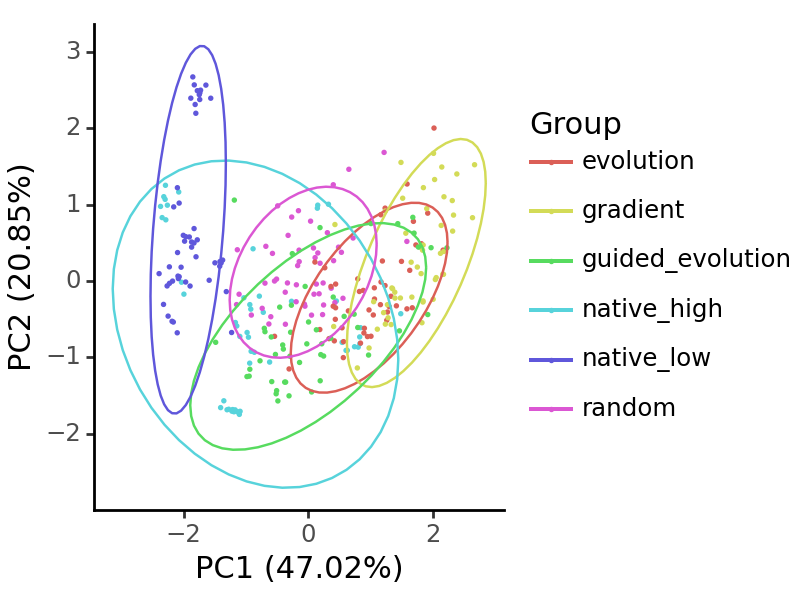

<Figure Size: (400 x 300)>

In [50]:
polygraph.visualize.pca_plot(gkm_emb, show_ellipse=True) + p9.theme(figure_size=(4,3))

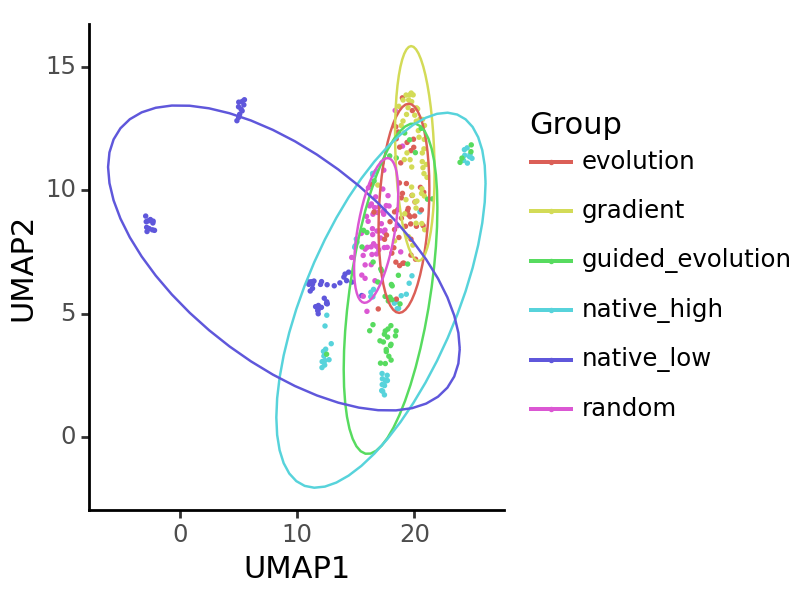

<Figure Size: (400 x 300)>

In [51]:
polygraph.visualize.umap_plot(gkm_emb, show_ellipse=True) + p9.theme(figure_size=(4,3))

In [52]:
# Performance of a classifier trained to separate each group from the reference
# It is even easier to distinguish sequences in this embedding!
gkm_emb.uns['svm_performance']

,Accuracy,AUROC
Group,,
native_low,1.00,1.00
random,1.00,1.00
evolution,0.98,0.98
gradient,1.00,1.00
guided_evolution,0.98,0.98


# 2. Model based evaluation

We can analyze sequences using sequence-to-function predictive models that are trained to recognize relevant sequence features. Here, we supply a model that has been trained to take DNA sequences as input and predict their promoter activity in yeast. You can also use your own trained pytorch model.

In [34]:
# Download yeast sequence-to-promoter activity model
# This was trained on yeast GPRA data from Vaishnav et al. 2022
!wget https://zenodo.org/records/10214625/files/yeast-model.pth

In [37]:
import torch
model = torch.load('yeast-model.pth')

/tmp/ipykernel_535662/3652003791.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


## 2.1 Predictions

First, we can use the model to predict the activity of real and synthetic promoters. Our model has been trained to make predictions in two media (complex and defined).

In [38]:
seqs[['complex_pred', 'defined_pred']] = polygraph.models.predict(seqs, model, batch_size=512, device=0)
seqs.head()

,Sequence,Group,GC Content,Sequence Length,edit,complex_pred,defined_pred
SeqID,,,,,,,
seq_0,GATGAGTGAAAAATCGTAATGAGTCAGCAAATCACTCTGTACGTTA...,native_high,0.34,80,0,2.78,2.69
seq_1,CATCGACTTATTTTTTTTTTTTGATGAAATTTTTCAGATTTTACAA...,native_high,0.26,80,0,2.79,2.69
seq_2,GCCTCTTATTTTTTTTTTTTTCGATTTTTGGCCCACAGGTCATATT...,native_high,0.46,80,0,2.72,2.64
seq_3,GATGAGTGAAAAATCGTAATGAGTCAGCAAATCACTGTGTACGTTA...,native_high,0.35,80,0,2.76,2.69
seq_4,AGAGCGACGCAAACAGCGCGCAGACTCTACGGGTAATAGACTCACA...,native_high,0.50,80,0,2.74,2.65


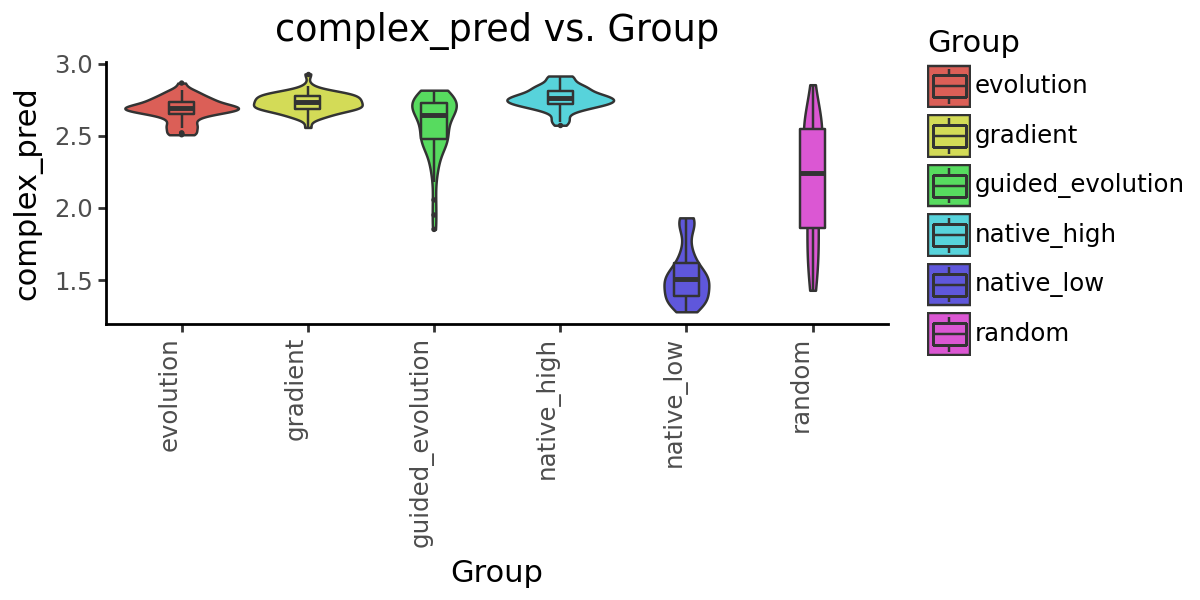

In [39]:
polygraph.visualize.boxplot(seqs, value_col='complex_pred') + p9.theme(figure_size=(6, 3))

## 2.2 Predicted cell type/condition specificity

Since we have made predictions in multiple conditions (media in this case), we can compute several metrics of specificity, i.e., to what extent are the sequences specific to complex medium. We show this just for illustration; the sequences here were not designed to be medium-specific.

In [40]:
# Metrics of how specific the promoter activity is to the 'complex' condition.
seqs = polygraph.models.cell_type_specificity(
    seqs, on_target_col='complex_pred', off_target_cols=['defined_pred'])

The `mingap` metric is the difference between the prediction in the on-target condition (complex) and the highest prediction in any off-target condition.

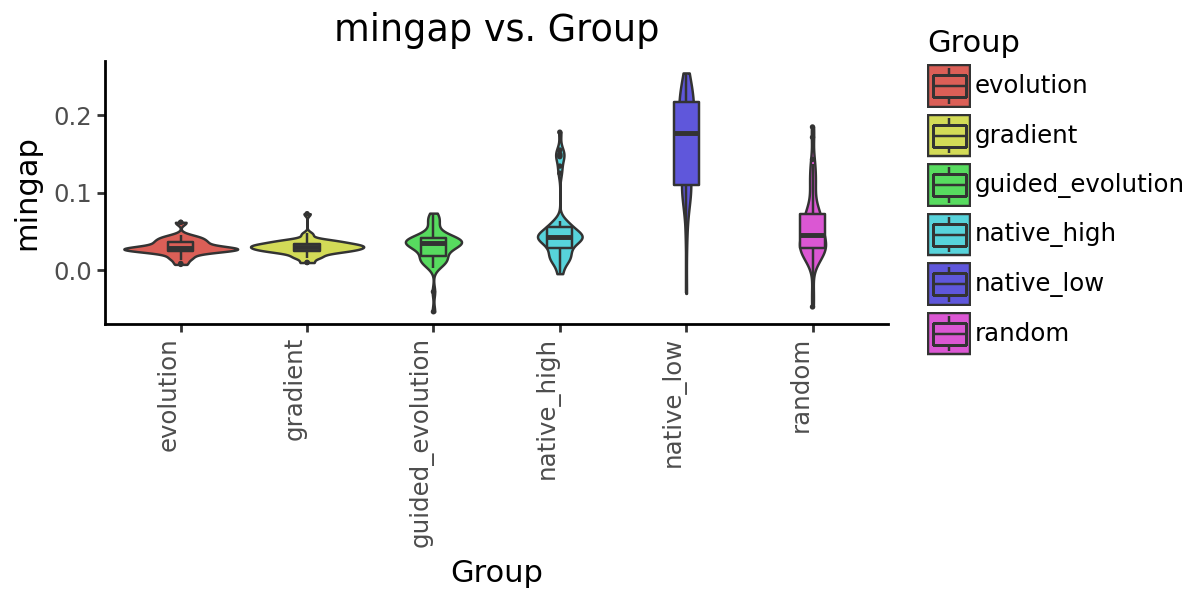

In [41]:
polygraph.visualize.boxplot(seqs, value_col='mingap') + p9.theme(figure_size=(6, 3))

## 2.3 Model embeddings

Just as we embedded the sequences in k-mer space, we can embed them in a latent space based on the initial layers of the model and measure their separation.

### 2.3.1 Compute model embeddings

In [42]:
model_emb = polygraph.models.get_embeddings(seqs, model, batch_size=512, drop_last_layers=4, device=0)
model_emb.shape

(300, 512)

### 2.3.2 Compute statistics

In [43]:
model_emb = polygraph.embedding.embedding_analysis(
    model_emb, seqs=seqs, reference_group='native_high', max_iter=10000, use_pca=True)

Creating AnnData object
PCA
Fraction of total variance explained by PCA components:  0.9946264
UMAP


/opt/conda/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
/opt/conda/lib/python3.11/site-packages/scanpy/preprocessing/_pca.py:317: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.


Differential feature abundance
1-NN statistics
Within-group KNN diversity
Euclidean distance to nearest reference
Distribution shift
Train groupwise classifiers


/opt/conda/lib/python3.11/site-packages/scikit_posthocs/_posthocs.py:368: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/opt/conda/lib/python3.11/site-packages/scikit_posthocs/_posthocs.py:371: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/opt/conda/lib/python3.11/site-packages/scikit_posthocs/_posthocs.py:368: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/opt/conda/lib/python3.11/site-packages/scikit_posthocs/_posthocs.py:3

### 2.3.3 Visualize

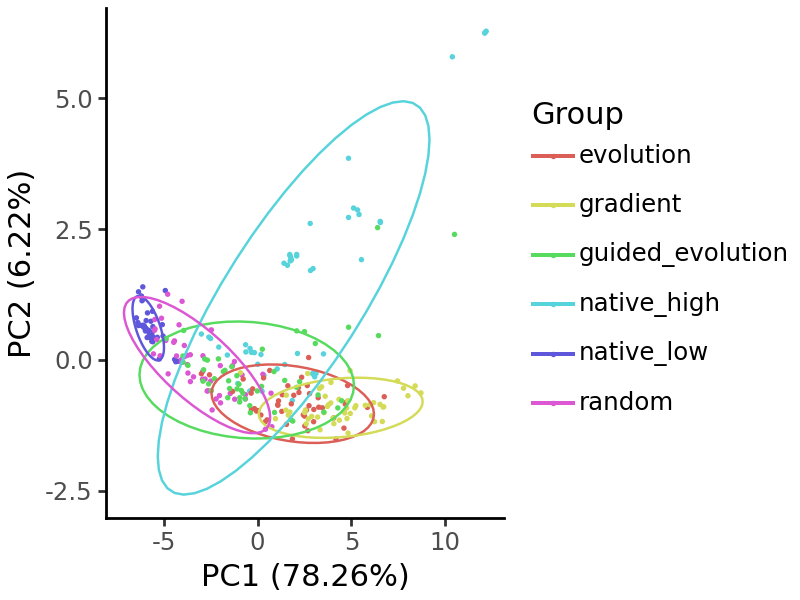

In [44]:
polygraph.visualize.pca_plot(model_emb) + p9.theme(figure_size=(4, 3))

### 2.3.4 1-Nearest Neighbor Fraction

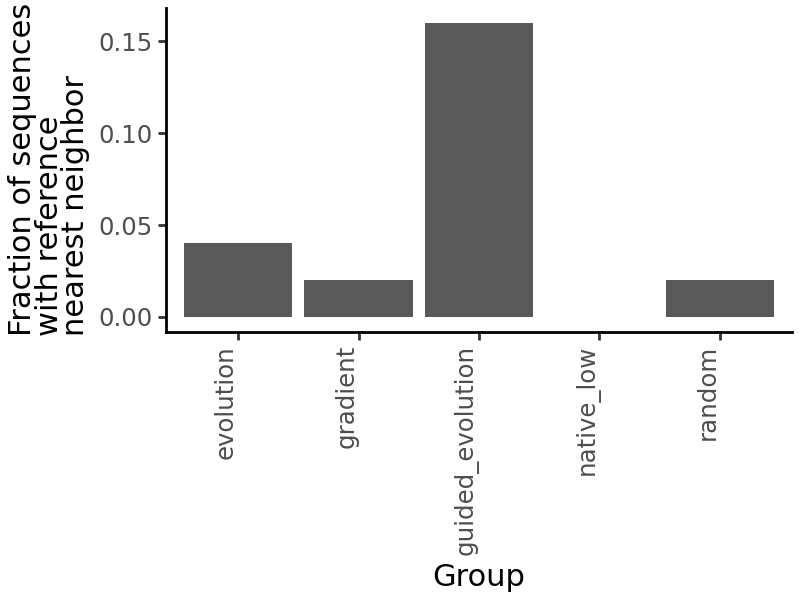

In [47]:
polygraph.visualize.one_nn_frac_plot(model_emb, reference_group="native_high") + p9.theme(figure_size=(4,3))

In [48]:
print(model_emb.uns["1NN_ref_prop_test"])

                  group_prop  ref_prop      pval      padj
Group                                                     
native_low              0.00      1.00  1.98e-29  9.91e-29
random                  0.02      0.92  2.73e-22  4.55e-22
evolution               0.04      0.90  6.18e-20  7.72e-20
gradient                0.02      0.92  2.73e-22  4.55e-22
guided_evolution        0.16      0.88  1.88e-13  1.88e-13


### 2.3.5 Distance to the closest reference sequence

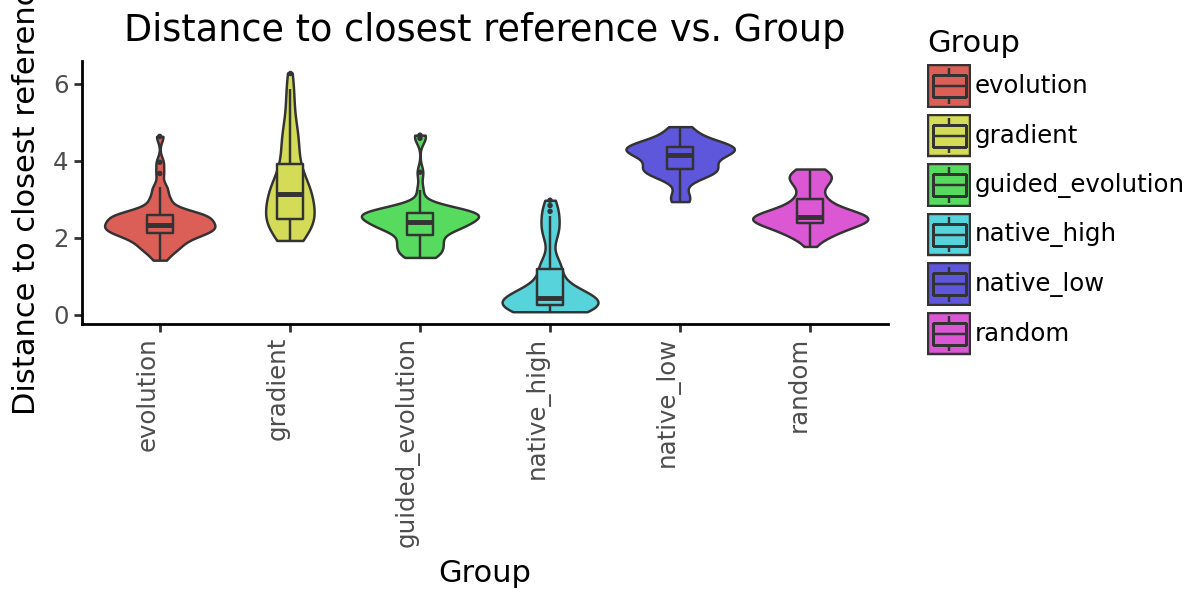

In [49]:
polygraph.visualize.boxplot(model_emb.obs, value_col='Distance to closest reference') + p9.theme(figure_size=(6, 3))

In [50]:
print(model_emb.uns['ref_dist_test'])

{'Kruskal': 1.8841914189330453e-36, 'Dunn':                   evolution  gradient  guided_evolution  native_high  \
evolution          1.00e+00  6.07e-05          7.64e-01     3.51e-06   
gradient           6.07e-05  1.00e+00          1.93e-04     4.34e-18   
guided_evolution   7.64e-01  1.93e-04          1.00e+00     8.68e-07   
native_high        3.51e-06  4.34e-18          8.68e-07     1.00e+00   
native_low         5.86e-14  4.51e-04          4.42e-13     1.34e-34   
random             6.21e-02  3.47e-02          1.11e-01     6.45e-11   

                  native_low    random  
evolution           5.86e-14  6.21e-02  
gradient            4.51e-04  3.47e-02  
guided_evolution    4.42e-13  1.11e-01  
native_high         1.34e-34  6.45e-11  
native_low          1.00e+00  1.76e-08  
random              1.76e-08  1.00e+00  }


### 2.3.6 Diversity (K-Nearest Neighbors distance)

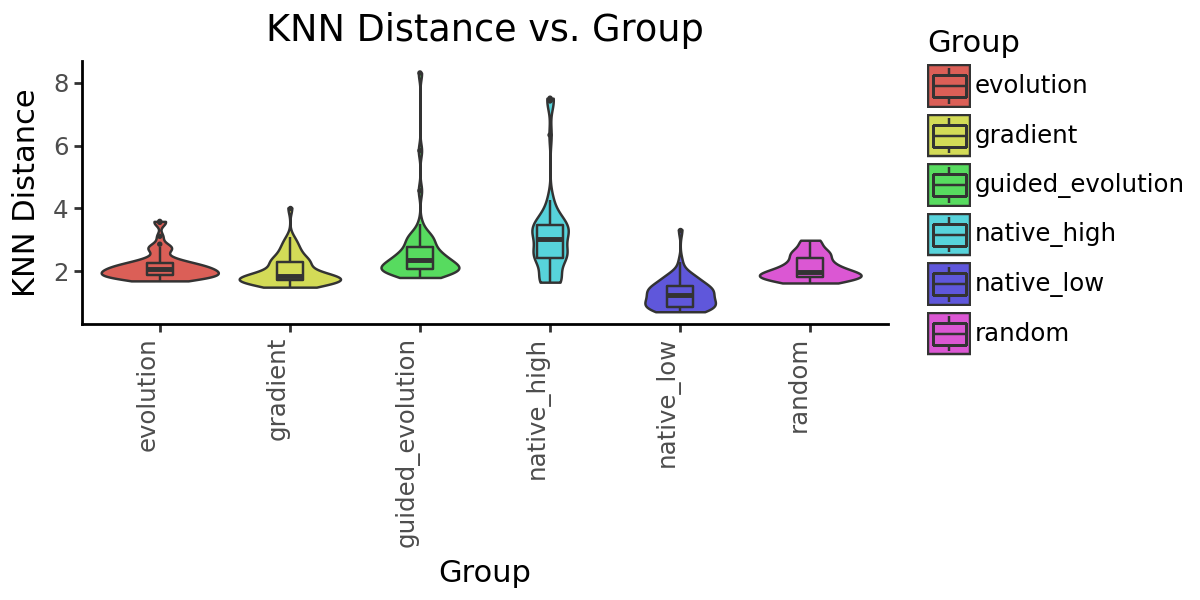

In [51]:
polygraph.visualize.boxplot(model_emb.obs, value_col='KNN Distance') + p9.theme(figure_size=(6,3))

In [52]:
print(model_emb.uns['knn_dist_test'])

{'Kruskal': 6.7265754987415136e-28, 'Dunn':                   evolution  gradient  guided_evolution  native_high  \
evolution          1.00e+00  1.02e-01          2.64e-02     1.86e-04   
gradient           1.02e-01  1.00e+00          8.54e-05     6.30e-08   
guided_evolution   2.64e-02  8.54e-05          1.00e+00     1.46e-01   
native_high        1.86e-04  6.30e-08          1.46e-01     1.00e+00   
native_low         5.02e-11  1.01e-06          4.52e-19     2.11e-25   
random             6.57e-01  2.09e-01          8.11e-03     3.53e-05   

                  native_low    random  
evolution           5.02e-11  6.57e-01  
gradient            1.01e-06  2.09e-01  
guided_evolution    4.52e-19  8.11e-03  
native_high         2.11e-25  3.53e-05  
native_low          1.00e+00  7.46e-10  
random              7.46e-10  1.00e+00  }


### 2.3.7 Distribution shift

In [53]:
model_emb.uns['dist_shift_test']

,t2_stat,fval,pval,padj
Group,,,,
native_high,0.00,0.00,1.00e+00,1.00e+00
native_low,48021.21,480.21,4.87e-52,2.92e-51
random,7540.48,75.40,5.85e-33,1.75e-32
evolution,1775.17,17.75,1.06e-18,1.59e-18
gradient,3713.42,37.13,7.71e-26,1.54e-25
guided_evolution,946.58,9.47,4.85e-13,5.82e-13


### 2.3.8 Classifier performance

In [54]:
model_emb.uns['svm_performance']

,Accuracy,AUROC
Group,,
native_low,1.0,1.0
random,1.0,1.0
evolution,1.0,1.0
gradient,1.0,1.0
guided_evolution,1.0,1.0


# 3. Evaluate motif content

Another way to compare sequences is based on their content of known TF-binding motifs. Here, we download fungal TF motifs from JASPAR and scan the real and synthetic sequences.

## 3.1 Scan all sequences with JASPAR motifs

In [51]:
# Download JASPAR motifs
meme_file = polygraph.input.download_jaspar("fungi")

--2024-11-18 00:29:04--  https://jaspar.elixir.no/download/data/2024/CORE/JASPAR2024_CORE_fungi_non-redundant_pfms_meme.txt
Resolving jaspar.elixir.no (jaspar.elixir.no)... 158.39.48.179
Connecting to jaspar.elixir.no (jaspar.elixir.no)|158.39.48.179|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 79182 (77K) [text/plain]
Saving to: ‘/opt/conda/lib/python3.11/site-packages/polygraph/resources/jaspar/JASPAR2024_CORE_fungi_non-redundant_pfms_meme.txt’

     0K .......... .......... .......... .......... .......... 64%  148K 0s
    50K .......... .......... .......                         100%  302M=0.3s

2024-11-18 00:29:07 (229 KB/s) - ‘/opt/conda/lib/python3.11/site-packages/polygraph/resources/jaspar/JASPAR2024_CORE_fungi_non-redundant_pfms_meme.txt’ saved [79182/79182]



In [55]:
%%time
# Scan
sites = polygraph.motifs.scan(seqs, '/opt/conda/lib/python3.11/site-packages/polygraph/resources/jaspar/JASPAR2024_CORE_fungi_non-redundant_pfms_meme.txt')
sites.head()

Read 178 motifs from file.
CPU times: user 3.27 s, sys: 0 ns, total: 3.27 s
Wall time: 3.27 s


,MotifID,SeqID,start,end,strand,Group
0,ARG80,seq_242,6,11,+,gradient
1,ARG80,seq_241,6,11,+,gradient
2,ARG80,seq_191,16,21,+,evolution
3,ARG80,seq_241,16,21,+,gradient
4,ARG80,seq_170,19,24,+,evolution


## 3.2 Motif count embedding

Just as we embedded the sequences by counting k-mers, we can count the frequency of motifs in each sequence and use this embedding to compute measures of separation between groups.

### 3.2.1 Compute sequence x motif count matrix

In [56]:
counts = polygraph.motifs.motif_frequencies(sites, seqs=seqs, normalize=True)
counts.iloc[:5, :5]

,ABF1,ABF2,ACE2,ADR1,AFT1
SeqID,,,,,
seq_0,0.03,0.0,0.0,0.00,0.0
seq_1,0.00,0.0,0.0,0.00,0.0
seq_2,0.00,0.0,0.0,0.01,0.0
seq_3,0.03,0.0,0.0,0.00,0.0
seq_4,0.00,0.0,0.0,0.00,0.0


### 3.2.2 Compute statistics

In [57]:
%%time
motif_emb = polygraph.embedding.embedding_analysis(
    counts, seqs, reference_group='native_high', use_pca=True)

Creating AnnData object
PCA
Fraction of total variance explained by PCA components:  0.887645360634361
UMAP


/opt/conda/lib/python3.11/site-packages/scanpy/preprocessing/_pca.py:317: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.


Differential feature abundance
1-NN statistics
Within-group KNN diversity
Euclidean distance to nearest reference
Distribution shift
Train groupwise classifiers


/opt/conda/lib/python3.11/site-packages/scikit_posthocs/_posthocs.py:368: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/opt/conda/lib/python3.11/site-packages/scikit_posthocs/_posthocs.py:371: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/opt/conda/lib/python3.11/site-packages/scikit_posthocs/_posthocs.py:368: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/opt/conda/lib/python3.11/site-packages/scikit_posthocs/_posthocs.py:3

CPU times: user 31.5 s, sys: 11.1 s, total: 42.6 s
Wall time: 1.68 s


### 3.2.3 Visualize

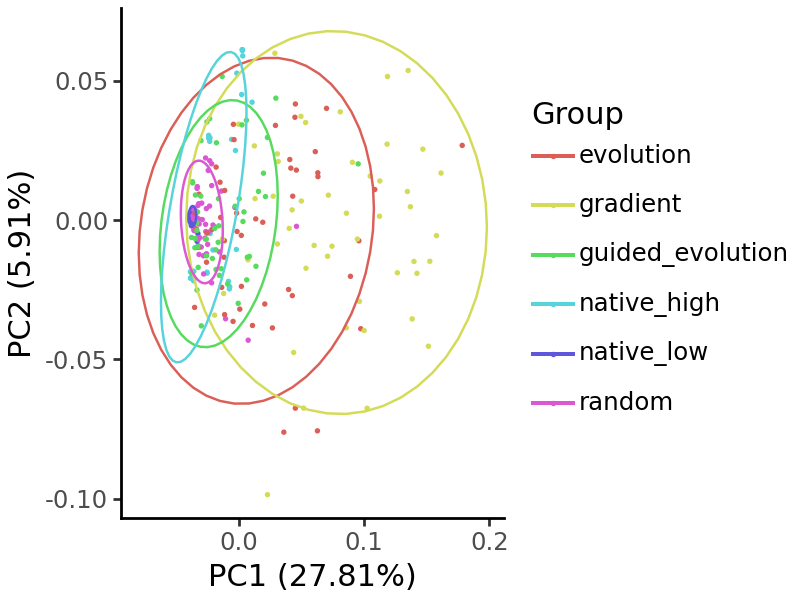

In [58]:
polygraph.visualize.pca_plot(motif_emb) + p9.theme(figure_size=(4,3))

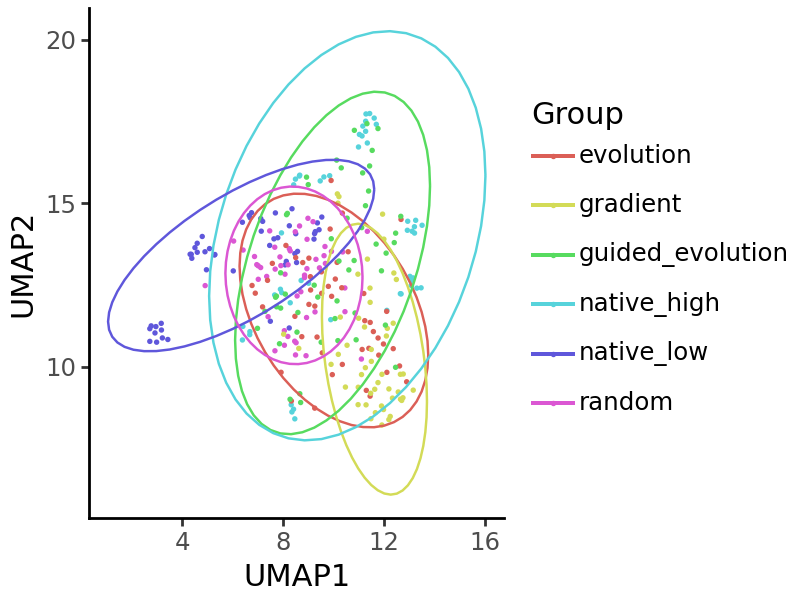

In [59]:
polygraph.visualize.umap_plot(motif_emb) + p9.theme(figure_size=(4,3))

### 3.2.4 Motif occurrence

/opt/conda/lib/python3.11/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


/opt/conda/lib/python3.11/site-packages/upsetplot/plotting.py:796: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=Tru

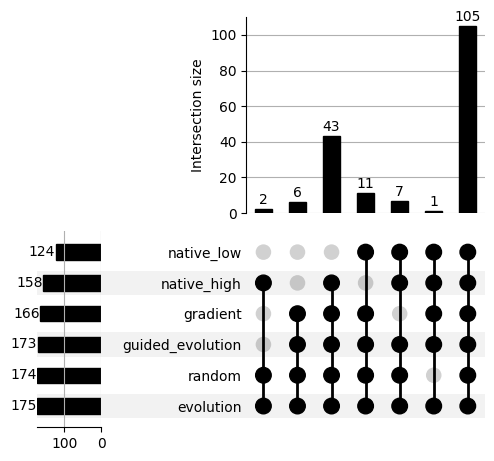

In [60]:
polygraph.visualize.upset_plot(motif_emb)

### 3.2.5 Differential motif abundance

In [61]:
test_results = motif_emb.uns["DE_test"]
test_results.head()

,Group,value,score,padj,log2FC
0,evolution,RSC30,5.20,3.46e-05,3.40
1,evolution,SWI4,4.65,2.86e-04,23.43
2,evolution,PDR3,4.06,2.86e-03,2.90
3,evolution,RSC3,3.98,3.00e-03,2.16
4,evolution,CHA4,3.79,5.24e-03,22.64


In [62]:
print("Number of differential motifs compared to reference")
print(test_results[test_results.padj < .01].Group.value_counts())

print("")

print("Top Differential motifs")
print(test_results[test_results.padj < .01].sort_values('padj').head())

Number of differential motifs compared to reference
Group
gradient      19
evolution      5
native_low     4
random         1
Name: count, dtype: int64

Top Differential motifs
        Group  value  score      padj  log2FC
175  gradient  RSC30   7.65  3.46e-12    4.57
176  gradient   RSC3   6.94  3.55e-10    3.18
177  gradient   MBP1   6.55  3.38e-09    3.82
178  gradient   SUT1   6.24  1.89e-08    3.63
179  gradient  DAL81   5.93  1.05e-07    6.06


### 3.2.6 1-Nearest Neighbor fraction

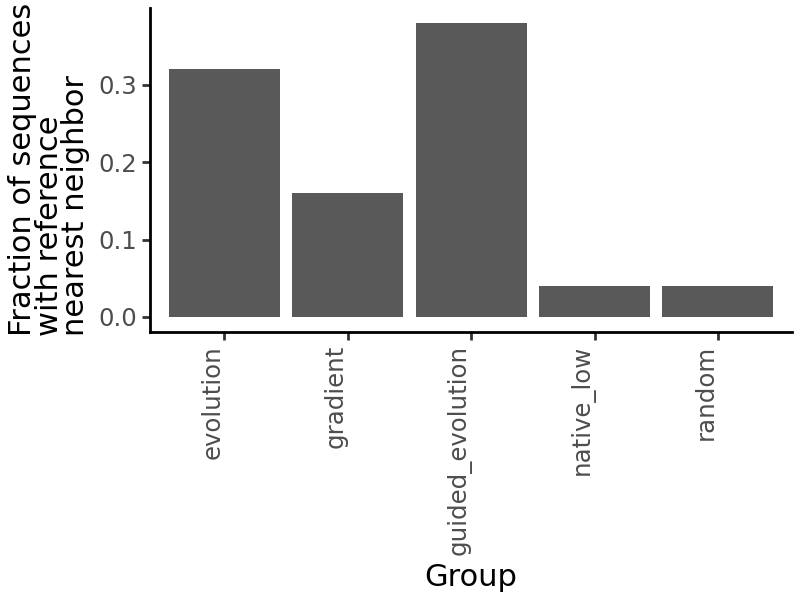

In [63]:
polygraph.visualize.one_nn_frac_plot(motif_emb, reference_group="native_high") + p9.theme(figure_size=(4,3))

In [64]:
print("p-values for proportion of sequences with native nearest neighbor")
print(motif_emb.uns["1NN_ref_prop_test"])

p-values for proportion of sequences with native nearest neighbor
                  group_prop  ref_prop      pval      padj
Group                                                     
native_low              0.04      0.94  4.87e-22  2.43e-21
random                  0.04      0.92  6.07e-21  1.52e-20
evolution               0.32      0.94  5.81e-11  7.26e-11
gradient                0.16      0.98  1.41e-18  2.36e-18
guided_evolution        0.38      0.90  6.96e-08  6.96e-08


### 3.2.7 Distance to closest reference sequence

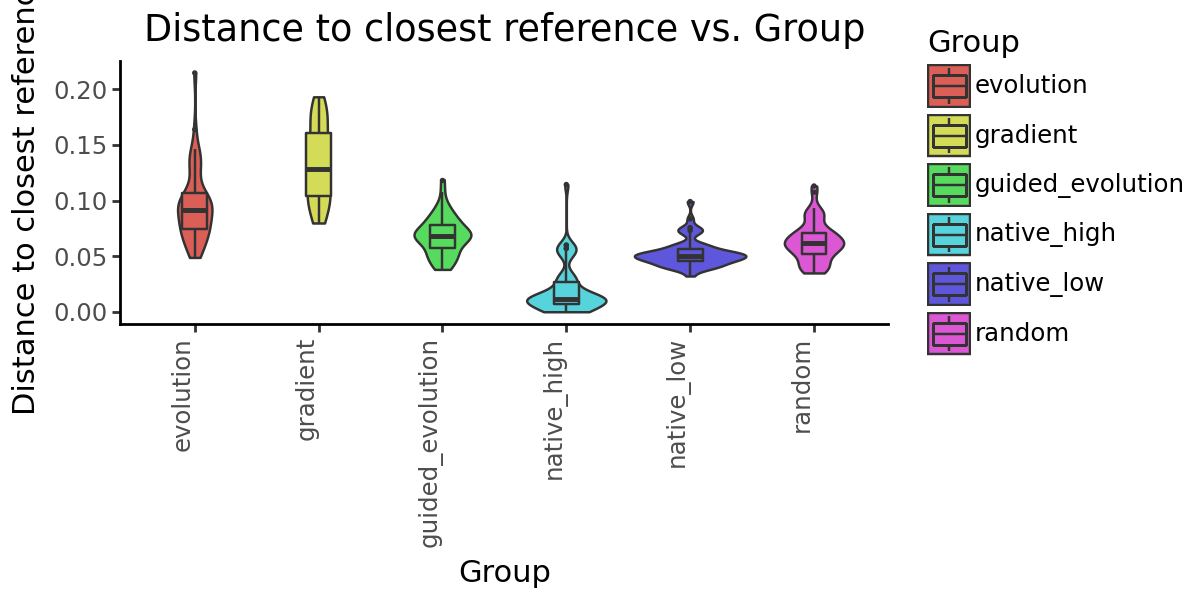

In [65]:
polygraph.visualize.boxplot(motif_emb.obs, value_col='Distance to closest reference') + p9.theme(figure_size=(6,3))

In [66]:
print("p-values for distance to closest reference")
print(motif_emb.uns["ref_dist_test"])

p-values for distance to closest reference
{'Kruskal': 3.235816668753655e-43, 'Dunn':                   evolution  gradient  guided_evolution  native_high  \
evolution          1.00e+00  3.79e-03          1.25e-03     2.23e-22   
gradient           3.79e-03  1.00e+00          8.51e-10     9.55e-37   
guided_evolution   1.25e-03  8.51e-10          1.00e+00     1.09e-10   
native_high        2.23e-22  9.55e-37          1.09e-10     1.00e+00   
native_low         2.67e-10  2.82e-20          2.10e-03     7.61e-04   
random             2.73e-05  1.58e-12          3.20e-01     3.49e-08   

                  native_low    random  
evolution           2.67e-10  2.73e-05  
gradient            2.82e-20  1.58e-12  
guided_evolution    2.10e-03  3.20e-01  
native_high         7.61e-04  3.49e-08  
native_low          1.00e+00  3.40e-02  
random              3.40e-02  1.00e+00  }


### 3.2.8 Diversity (K-Nearest Neighbor distance)

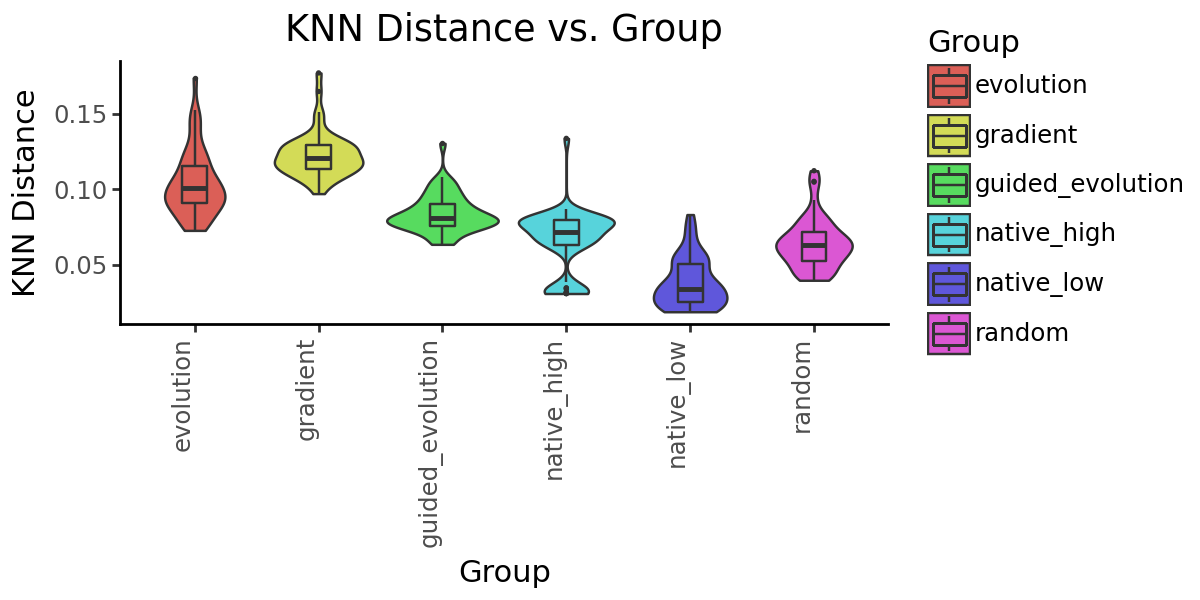

In [67]:
polygraph.visualize.boxplot(motif_emb.obs, value_col='KNN Distance') + p9.theme(figure_size=(6,3))

In [69]:
print("p-values for KNN diversity")
print(motif_emb.uns["knn_dist_test"])

p-values for KNN diversity
{'Kruskal': 2.2143151486239496e-46, 'Dunn':                   evolution  gradient  guided_evolution  native_high  \
evolution          1.00e+00  1.21e-02          3.55e-03     1.54e-09   
gradient           1.21e-02  1.00e+00          7.41e-08     1.31e-17   
guided_evolution   3.55e-03  7.41e-08          1.00e+00     1.71e-03   
native_high        1.54e-09  1.31e-17          1.71e-03     1.00e+00   
native_low         6.47e-24  2.07e-36          7.43e-13     6.34e-05   
random             1.97e-11  3.52e-20          1.57e-04     4.97e-01   

                  native_low    random  
evolution           6.47e-24  1.97e-11  
gradient            2.07e-36  3.52e-20  
guided_evolution    7.43e-13  1.57e-04  
native_high         6.34e-05  4.97e-01  
native_low          1.00e+00  7.94e-04  
random              7.94e-04  1.00e+00  }


### 3.2.9 Distribution shift

In [70]:
motif_emb.uns['dist_shift_test']

,t2_stat,fval,pval,padj
Group,,,,
native_high,0.00,0.00,1.00e+00,1.00e+00
native_low,3875.74,38.76,2.90e-26,1.74e-25
random,1644.99,16.45,5.47e-18,1.35e-17
evolution,1207.63,12.08,3.60e-15,5.40e-15
gradient,1629.12,16.29,6.73e-18,1.35e-17
guided_evolution,446.23,4.46,3.39e-07,4.07e-07


### 3.2.10 Classifier performance

In [71]:
motif_emb.uns['svm_performance']

,Accuracy,AUROC
Group,,
native_low,0.99,0.99
random,0.93,0.93
evolution,0.85,0.85
gradient,0.97,0.97
guided_evolution,0.83,0.83


## 3.3 Motif positions

Instead of only comparing motif frequencies, we can also compare motif positions across groups. Here, we compare the positioning of the `RSC30` motif.

In [72]:
test_results = polygraph.stats.kruskal_dunn(sites[sites.MotifID=='RSC30'], val_col='start')
test_results['Kruskal']

0.00642637465639194

In [73]:
test_results['Dunn'].style.applymap(lambda x: "background-color: red" if x<.01 else None)

/tmp/ipykernel_535662/4098636107.py:1: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.


,evolution,gradient,guided_evolution,native_high,random
evolution,1.000000,0.579063,0.887738,0.005411,0.579063
gradient,0.579063,1.000000,0.579063,0.002665,0.579063
guided_evolution,0.887738,0.579063,1.000000,0.008421,0.579063
native_high,0.005411,0.002665,0.008421,1.000000,0.007675
random,0.579063,0.579063,0.579063,0.007675,1.000000


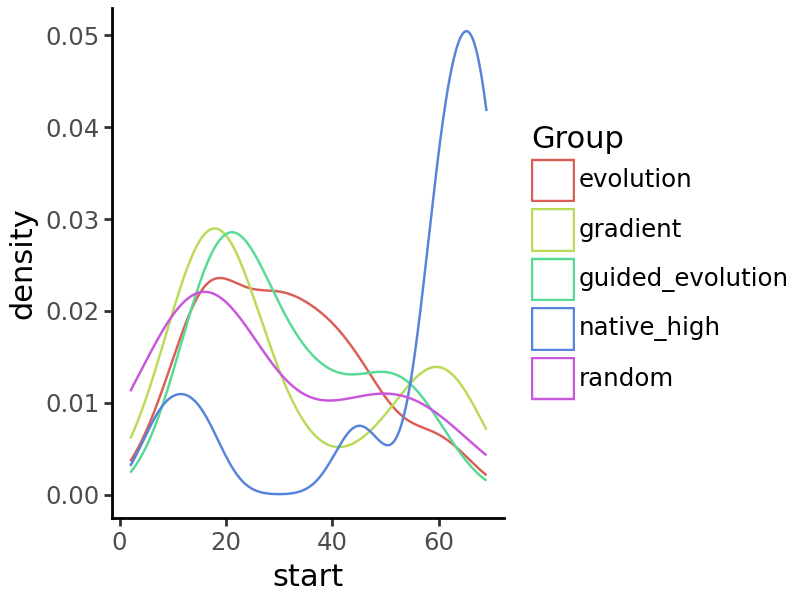

In [74]:
polygraph.visualize.densityplot(sites[sites.MotifID=='RSC30'], value_col='start') + p9.theme(figure_size=(4,3))

## 3.4 Motif pair syntax

We can also compare more complex regulatory syntax, such as: how often do two motifs occur together in a sequence? Do they tend to occur in the same orientation vs. opposite orientations? Do they tend to occur separated by the same distance?

The first step is to list all pairs of motifs, along with their orientation and distance, in every sequence:

### 3.4.1 Identify motif pairs

In [75]:
motif_pairs = polygraph.motifs.get_motif_pairs(sites)
motif_pairs.head()

,MotifID,orientation,distance
SeqID,,,
seq_0,"(ARG80, INO4)",same,50.5
seq_0,"(ARG80, MAC1)",same,4.0
seq_0,"(ARG80, MOT3)",same,27.0
seq_0,"(ARG80, YAP5)",same,26.0
seq_0,"(ARG80, YAP7)",opposite,0.5


### 3.4.2 Differential abundance of motif pairs

We compare the abundance of all pairs of motifs between each synthetic group and the reference group ("native_high"). This would take a long time to run for every pair, so we filter only pairs which occur in at least 20% of sequences in any group.

In [76]:
pair_diff_abundance = polygraph.motifs.motif_pair_differential_abundance(
    motif_pairs, seqs, reference_group="native_high", max_prop_cutoff=0.2)

pair_diff_abundance.head()

Selected 1204 pairs based on in-group proportion


/opt/conda/lib/python3.11/site-packages/polygraph/stats.py:68: RuntimeWarning: divide by zero encountered in log2
/opt/conda/lib/python3.11/site-packages/polygraph/stats.py:68: RuntimeWarning: divide by zero encountered in log2
/opt/conda/lib/python3.11/site-packages/polygraph/stats.py:68: RuntimeWarning: divide by zero encountered in log2
/opt/conda/lib/python3.11/site-packages/polygraph/stats.py:68: RuntimeWarning: divide by zero encountered in log2
/opt/conda/lib/python3.11/site-packages/polygraph/stats.py:68: RuntimeWarning: divide by zero encountered in log2
/opt/conda/lib/python3.11/site-packages/polygraph/stats.py:68: RuntimeWarning: divide by zero encountered in log2
/opt/conda/lib/python3.11/site-packages/polygraph/stats.py:68: RuntimeWarning: divide by zero encountered in log2
/opt/conda/lib/python3.11/site-packages/polygraph/stats.py:68: RuntimeWarning: divide by zero encountered in log2
/opt/conda/lib/python3.11/site-packages/polygraph/stats.py:68: RuntimeWarning: divide by

,Group,group_prop,ref_prop,log2FC,pval,padj,MotifID
0,native_low,0.02,0.22,-3.46,3.79e-03,0.01,"(ARG80, INO4)"
1,random,0.04,0.22,-2.46,1.47e-02,0.04,"(ARG80, INO4)"
2,evolution,0.04,0.22,-2.46,1.47e-02,0.04,"(ARG80, INO4)"
3,gradient,0.02,0.22,-3.46,3.79e-03,0.01,"(ARG80, INO4)"
4,guided_evolution,0.10,0.22,-1.14,1.71e-01,0.34,"(ARG80, INO4)"


In [77]:
print("Number of differential motif pairs compared to reference")
print(pair_diff_abundance[pair_diff_abundance.padj < .01].Group.value_counts())

print("")

print("Top Differential motif pairs")
print(pair_diff_abundance[pair_diff_abundance.padj < .01].sort_values('padj').head())

Number of differential motif pairs compared to reference
Group
gradient            742
evolution           243
native_low          232
random              117
guided_evolution     30
Name: count, dtype: int64

Top Differential motif pairs
         Group  group_prop  ref_prop  log2FC      pval      padj  \
1158  gradient        0.86      0.02    5.43  2.03e-19  1.22e-15   
1873  gradient        0.78      0.00     inf  8.29e-18  2.49e-14   
1138  gradient        0.80      0.02    5.32  5.13e-17  1.03e-13   
1173  gradient        0.90      0.10    3.17  9.00e-17  1.36e-13   
1353  gradient        0.78      0.02    5.29  2.73e-16  3.29e-13   

             MotifID  
1158   (RSC3, RSC30)  
1873    (MBP1, RSC3)  
1138   (TEA1, RSC30)  
1173  (RSC30, RSC30)  
1353   (SUT1, RSC30)  


### 3.4.3 Differential orientation of motif pairs

How many motif pairs occur in different orientations (same strand vs. opposite strand) in synthetic sequences, compared to reference sequences? Here, we filter those pairs that occur in at least 20% of the reference group.

In [78]:
pair_diff_orientation = polygraph.motifs.motif_pair_differential_orientation(
    motif_pairs, seqs, reference_group="native_high", ref_prop_cutoff=0.2)

pair_diff_orientation.head()

Selected 197 pairs based on in-group proportion


/opt/conda/lib/python3.11/site-packages/polygraph/stats.py:68: RuntimeWarning: divide by zero encountered in log2
/opt/conda/lib/python3.11/site-packages/polygraph/stats.py:68: RuntimeWarning: divide by zero encountered in log2
/opt/conda/lib/python3.11/site-packages/polygraph/stats.py:68: RuntimeWarning: divide by zero encountered in log2
/opt/conda/lib/python3.11/site-packages/polygraph/stats.py:68: RuntimeWarning: divide by zero encountered in log2
/opt/conda/lib/python3.11/site-packages/polygraph/stats.py:68: RuntimeWarning: divide by zero encountered in log2
/opt/conda/lib/python3.11/site-packages/polygraph/stats.py:68: RuntimeWarning: divide by zero encountered in log2
/opt/conda/lib/python3.11/site-packages/polygraph/stats.py:68: RuntimeWarning: divide by zero encountered in log2
/opt/conda/lib/python3.11/site-packages/polygraph/stats.py:68: RuntimeWarning: divide by zero encountered in scalar divide
/opt/conda/lib/python3.11/site-packages/polygraph/stats.py:68: RuntimeWarning: 

,Group,group_prop,ref_prop,log2FC,pval,padj,MotifID
0,random,0.50,1.0,-1.00,0.15,0.63,"(ARG80, INO4)"
1,evolution,0.00,1.0,-inf,0.01,0.18,"(ARG80, INO4)"
2,gradient,1.00,1.0,0.00,1.00,1.00,"(ARG80, INO4)"
3,guided_evolution,0.67,1.0,-0.58,0.11,0.51,"(ARG80, INO4)"
4,native_low,0.00,1.0,-inf,0.08,0.46,"(ARG80, INO4)"


In [82]:
print("Number of differentially oriented motif pairs compared to reference")
print(pair_diff_orientation[pair_diff_orientation.padj <= .01].Group.value_counts())

print("")

print("Top Differentially oriented motif pairs")
print(pair_diff_orientation[pair_diff_orientation.padj <= .01].sort_values('padj').head())

Number of differentially oriented motif pairs compared to reference
Series([], Name: count, dtype: int64)

Top Differentially oriented motif pairs
Empty DataFrame
Columns: [Group, group_prop, ref_prop, log2FC, pval, padj, MotifID]
Index: []


### 3.4.4 Differential spacing of motif pairs

How many motif pairs occur separated by different distances in synthetic sequences, compared to reference sequences? Here, we filter those pairs that occur in at least 20% of the reference group.

In [80]:
pair_diff_dist = polygraph.motifs.motif_pair_differential_distance(
    motif_pairs, seqs, reference_group="native_high", ref_prop_cutoff=0.2)

pair_diff_dist.head()

Selected 197 pairs based on in-group proportion


/opt/conda/lib/python3.11/site-packages/polygraph/stats.py:125: RuntimeWarning: divide by zero encountered in log2
/opt/conda/lib/python3.11/site-packages/polygraph/stats.py:125: RuntimeWarning: divide by zero encountered in scalar divide
/opt/conda/lib/python3.11/site-packages/polygraph/stats.py:125: RuntimeWarning: divide by zero encountered in log2
/opt/conda/lib/python3.11/site-packages/polygraph/stats.py:125: RuntimeWarning: invalid value encountered in scalar divide
/opt/conda/lib/python3.11/site-packages/polygraph/stats.py:125: RuntimeWarning: divide by zero encountered in scalar divide
/opt/conda/lib/python3.11/site-packages/polygraph/stats.py:125: RuntimeWarning: invalid value encountered in scalar divide
/opt/conda/lib/python3.11/site-packages/polygraph/stats.py:125: RuntimeWarning: divide by zero encountered in scalar divide
/opt/conda/lib/python3.11/site-packages/polygraph/stats.py:125: RuntimeWarning: invalid value encountered in scalar divide
/opt/conda/lib/python3.11/sit

,index,Group,group_mean,ref_mean,log2FC,pval,padj,MotifID
0,0,random,18.00,50.5,-1.49,9.84e-04,5.52e-03,"(ARG80, INO4)"
1,0,evolution,17.50,50.5,-1.53,9.84e-04,5.52e-03,"(ARG80, INO4)"
2,0,gradient,32.50,50.5,-0.64,2.57e-03,9.46e-03,"(ARG80, INO4)"
3,0,guided_evolution,21.33,50.5,-1.24,1.31e-04,1.45e-03,"(ARG80, INO4)"
4,0,native_low,7.50,50.5,-2.75,2.57e-03,9.46e-03,"(ARG80, INO4)"


In [81]:
sig_diff_dist = pair_diff_dist[(pair_diff_dist.padj <= .01) & (pair_diff_dist.ref_mean > 5)]

print("Number of differentially spaced motif pairs compared to reference")
print(sig_diff_dist.Group.value_counts())

print("")

print("Top Differentially spaced motif pairs")
print(sig_diff_dist.sort_values('padj').head())

Number of differentially spaced motif pairs compared to reference
Group
guided_evolution    44
evolution           23
random              15
native_low          15
gradient            14
Name: count, dtype: int64

Top Differentially spaced motif pairs
     index             Group  group_mean  ref_mean  log2FC      pval  \
212      0          gradient       15.42     34.97   -1.18  5.07e-08   
207      0  guided_evolution       18.57     30.29   -0.71  9.99e-08   
325      0  guided_evolution       25.19      7.02    1.84  1.46e-07   
171      0          gradient        6.50     29.34   -2.17  3.32e-07   
310      0  guided_evolution       24.80      7.02    1.82  5.27e-07   

         padj          MotifID  
212  1.79e-06  (SFP1, YPR015C)  
207  2.85e-06     (SFP1, ABF1)  
325  3.98e-06  (YPR015C, GCN4)  
171  8.66e-06    (NDT80, SFP1)  
310  1.22e-05  (YPR013C, GCN4)  


## 3.5 NMF

Non-Negative Matrix Factorization (NMF) identifies co-occurring groups of motifs ('factors')
and their contribution to each sequence.

In [83]:
W, H, test_results = polygraph.motifs.nmf(counts, seqs, reference_group='native_high', n_components=10)

- W: Contribution of factors to sequences
- H: Contribution of motifs to factors
- test_results: Significance testing for the contribution of factors in each group of synthetic sequences vs. the reference group. 

First, let us visualize the H matrix. This shows what the 10 factors are - they are combinations of motifs that tend to co-occur.

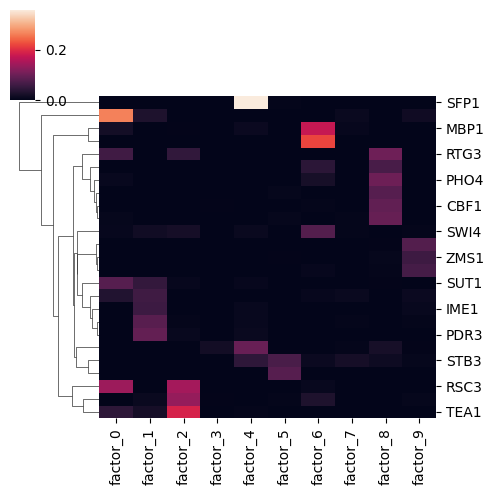

In [84]:
# Motifs that contribute to each factor
polygraph.visualize.plot_factors_nmf(H, n_features=25, figsize=(5,5))

Next, let us visualize the W matrix. This shows how much each factor contributes to each sequence.

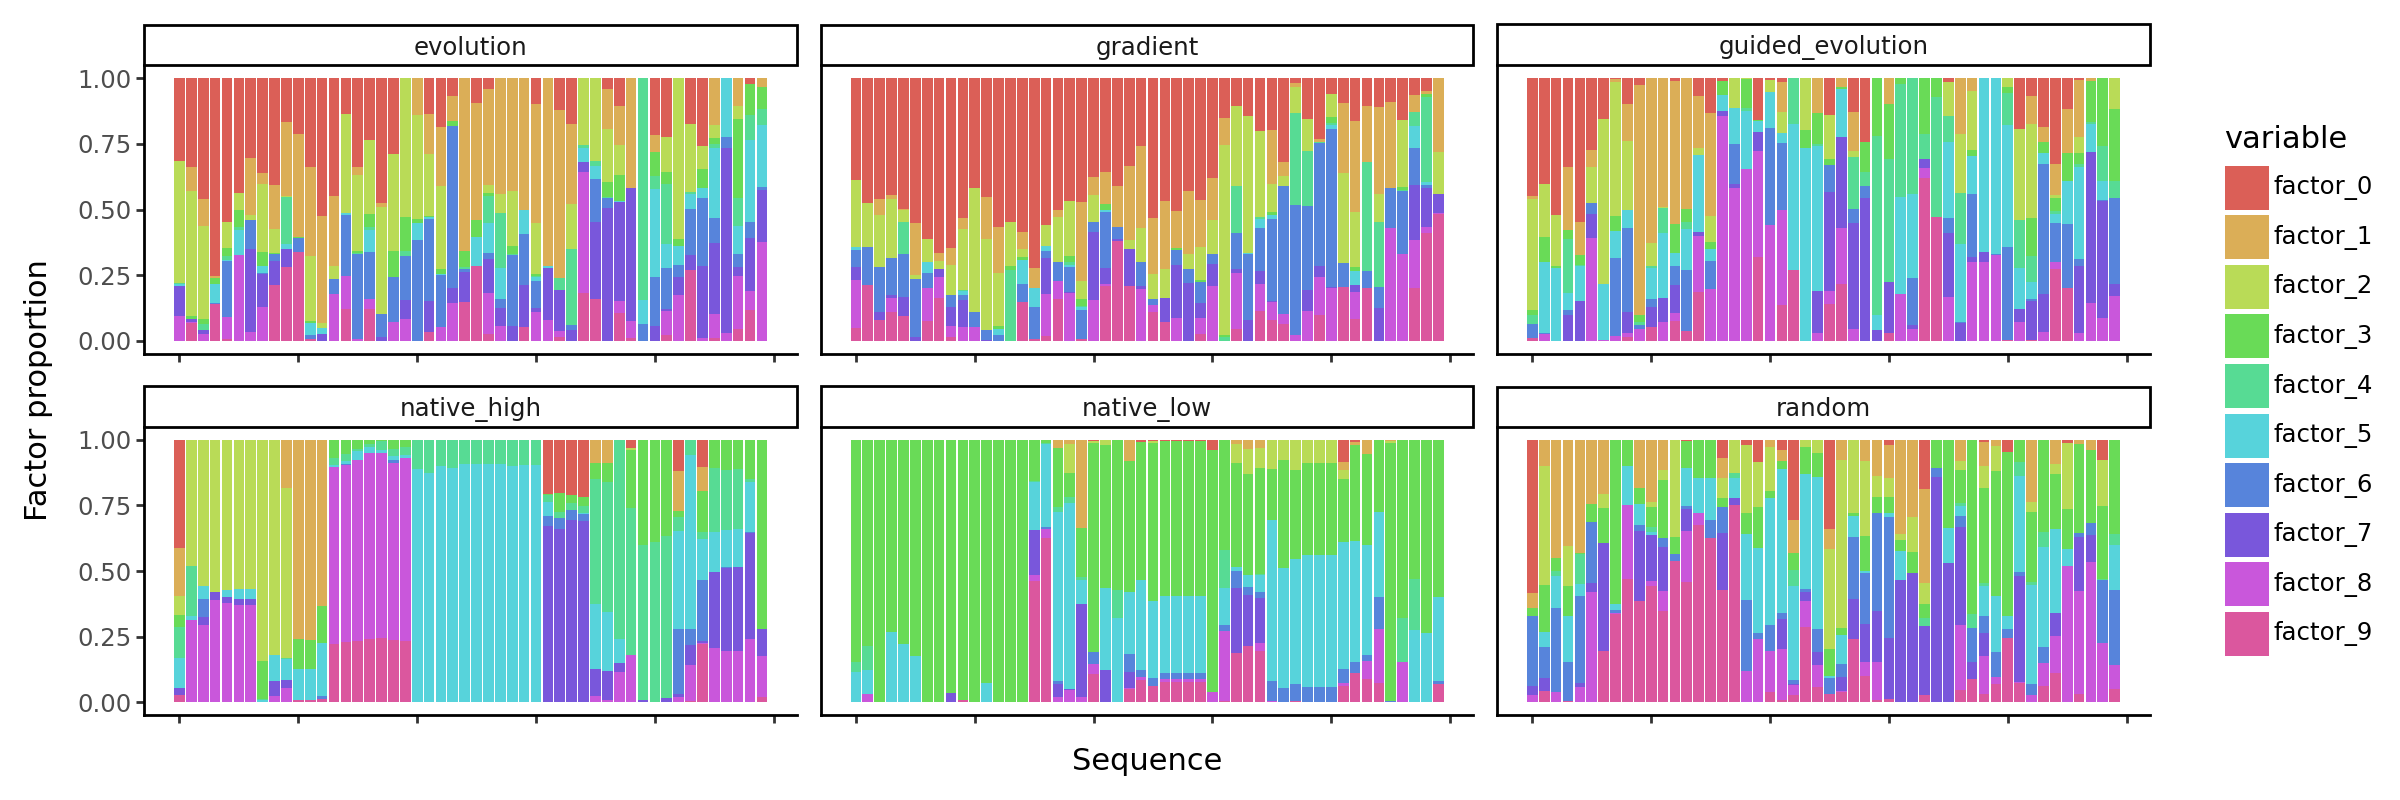

In [85]:
polygraph.visualize.plot_seqs_nmf(W) + p9.theme(figure_size=(12, 4))

Finally, test_results tells us whether any factors contribute differently to synthetic vs. real sequences:

In [86]:
test_results.head()

,Group,group_mean,ref_mean,log2FC,pval,padj,factor
0,native_low,8.13e-05,4.45e-03,-5.78,9.22e-01,9.41e-01,factor_0
0,random,5.68e-03,4.45e-03,0.35,1.86e-01,2.44e-01,factor_0
0,evolution,6.13e-02,4.45e-03,3.78,2.37e-08,1.98e-07,factor_0
0,gradient,1.55e-01,4.45e-03,5.12,1.62e-17,8.11e-16,factor_0
0,guided_evolution,2.07e-02,4.45e-03,2.22,9.73e-05,3.47e-04,factor_0


In [87]:
# How many factors contribute differently in each synthetic group vs. the reference?
test_results[test_results.padj < .01].Group.value_counts()

Group
gradient            8
evolution           6
random              5
native_low          4
guided_evolution    3
Name: count, dtype: int64

### 3.6 Filter important motifs by ISM

It may be that not all TF binding motifs are functionally relevant. For example, motifs for that are only expressed in conditions or cell types that we do not intend to test. One way to ensure that we are considering only relevant motifs in our analysis is to filter motifs based on their average ISM (In-silico mutagenesis) score, using a sequence-to-function model trained in the relevant condition.

### 3.6.1 Perform ISM for all sequences.

In [88]:
# Calculate an importance score for each base in each sequence using In Silico Mutagenesis
ism = polygraph.models.ism_score(model, seqs, batch_size=512, device=0)
ism.shape

(300, 80)

### 3.6.2 Calculate average ISM score for each occurrence of each motif

In [89]:
sites = polygraph.motifs.score_sites(sites, seqs, ism)
sites.head()

,MotifID,SeqID,start,end,strand,Group,mid,score
0,ARG80,seq_242,6,11,+,gradient,8.5,9.36e-03
1,ARG80,seq_241,6,11,+,gradient,8.5,7.13e-03
2,ARG80,seq_191,16,21,+,evolution,18.5,1.18e-02
3,ARG80,seq_241,16,21,+,gradient,18.5,1.68e-02
4,ARG80,seq_170,19,24,+,evolution,21.5,2.01e-02


### 3.6.3 Select the top 50 motifs most important motifs across the dataset

In [90]:
top_motifs = sites.groupby('MotifID').score.max().sort_values(ascending=False).head(50).index.tolist()
top_motifs[:10]

['ASG1',
 'ECM22',
 'YER184C',
 'SIP4',
 'PUT3',
 'CAT8',
 'REB1',
 'NSI1',
 'YPR022C',
 'MIG1']

### 3.6.4 Embedding analysis with selected motifs only

In [91]:
top_motif_sites = sites[sites.MotifID.isin(top_motifs)]

In [92]:
counts = polygraph.motifs.motif_frequencies(top_motif_sites, seqs=seqs, normalize=True)
counts.iloc[:5, :5]

,ABF1,ACE2,ADR1,ASG1,CAT8
SeqID,,,,,
seq_0,0.03,0.0,0.00,0.0,0.0
seq_1,0.00,0.0,0.00,0.0,0.0
seq_2,0.00,0.0,0.01,0.0,0.0
seq_3,0.03,0.0,0.00,0.0,0.0
seq_4,0.00,0.0,0.00,0.0,0.0


In [95]:
motif_emb_2 = polygraph.embedding.embedding_analysis(
    counts, seqs, reference_group='native_high', use_pca=True)

Creating AnnData object
PCA
Fraction of total variance explained by PCA components:  0.9999999999999999
UMAP


/opt/conda/lib/python3.11/site-packages/scanpy/preprocessing/_pca.py:317: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.


Differential feature abundance
1-NN statistics
Within-group KNN diversity
Euclidean distance to nearest reference
Distribution shift


/opt/conda/lib/python3.11/site-packages/scikit_posthocs/_posthocs.py:368: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/opt/conda/lib/python3.11/site-packages/scikit_posthocs/_posthocs.py:371: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/opt/conda/lib/python3.11/site-packages/scikit_posthocs/_posthocs.py:368: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/opt/conda/lib/python3.11/site-packages/scikit_posthocs/_posthocs.py:3

Train groupwise classifiers


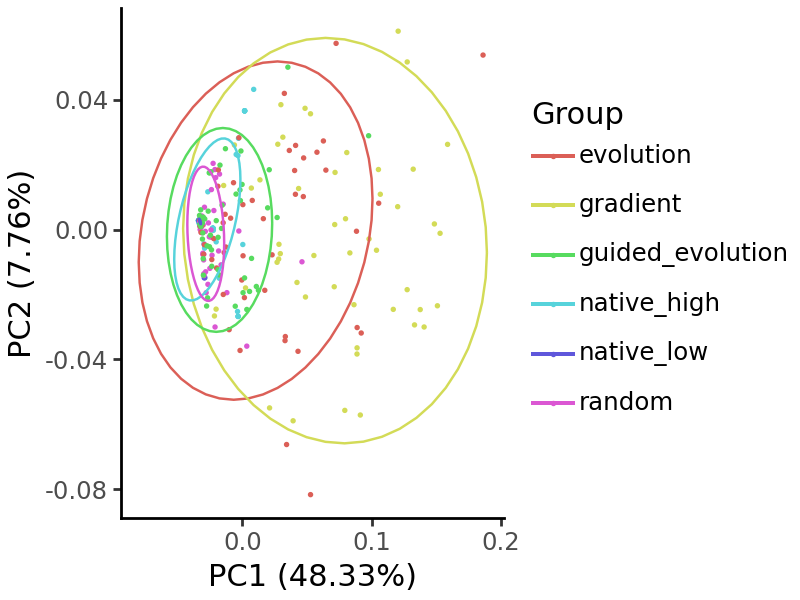

In [96]:
polygraph.visualize.pca_plot(motif_emb_2) + p9.theme(figure_size=(4,3))

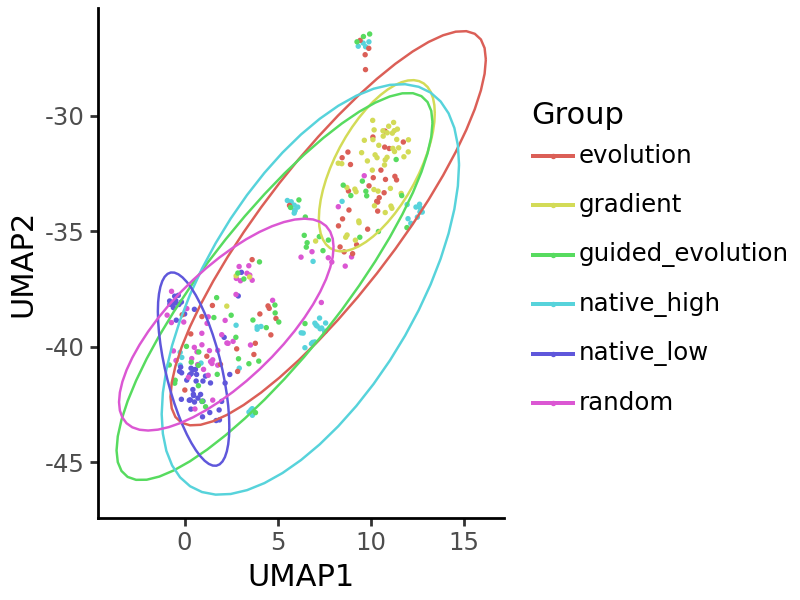

In [98]:
polygraph.visualize.umap_plot(motif_emb_2) + p9.theme(figure_size=(4,3))

p-values for distance to closest reference
{'Kruskal': 4.253811058390571e-47, 'Dunn':                   evolution  gradient  guided_evolution  native_high  \
evolution          1.00e+00  2.76e-03          4.58e-03     1.20e-21   
gradient           2.76e-03  1.00e+00          6.06e-09     3.03e-36   
guided_evolution   4.58e-03  6.06e-09          1.00e+00     1.95e-11   
native_high        1.20e-21  3.03e-36          1.95e-11     1.00e+00   
native_low         1.37e-14  6.40e-27          1.03e-06     6.79e-02   
random             1.43e-04  1.18e-11          3.18e-01     9.56e-09   

                  native_low    random  
evolution           1.37e-14  1.43e-04  
gradient            6.40e-27  1.18e-11  
guided_evolution    1.03e-06  3.18e-01  
native_high         6.79e-02  9.56e-09  
native_low          1.00e+00  1.00e-04  
random              1.00e-04  1.00e+00  }


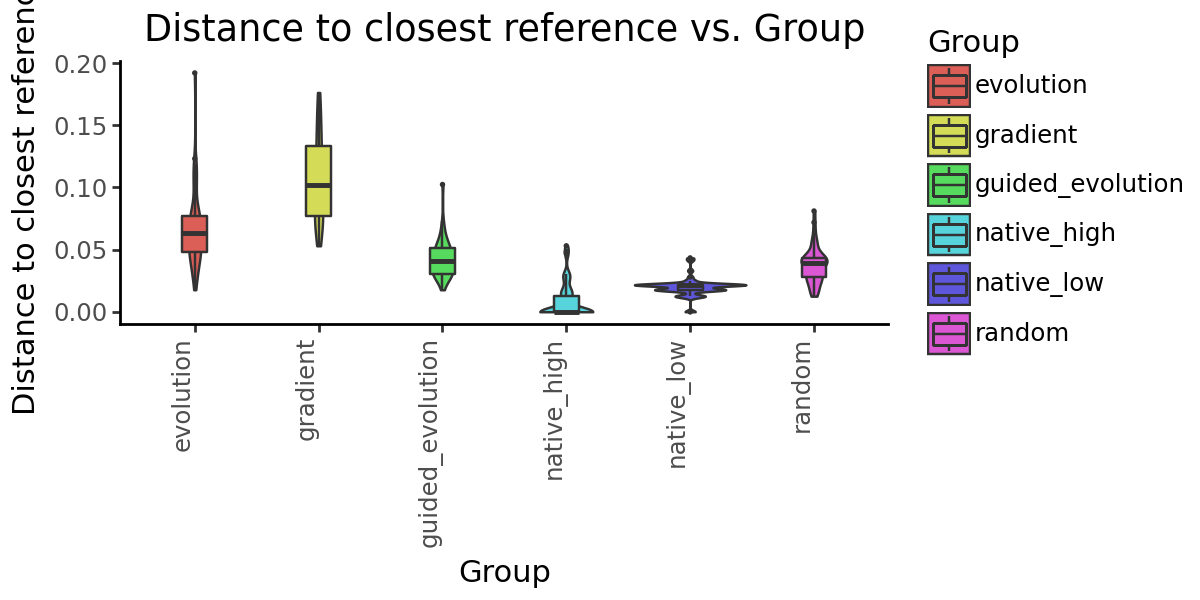

In [97]:
# Distance to reference
print("p-values for distance to closest reference")
print(motif_emb_2.uns["ref_dist_test"])

polygraph.visualize.boxplot(motif_emb_2.obs, value_col='Distance to closest reference') + p9.theme(figure_size=(6,3))